[View in Colaboratory](https://colab.research.google.com/github/gonzalezf/Tarea3-INF395/blob/master/Tarea3.ipynb)

<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 3 - Aplicaciones de Redes Neuronales </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Modelos Generativos profundos: VAE (*Variational Autoencoder*) y GAN (*Generative Adversarial Network*).
* Arquitectura encoder-decoder y mecanismo de antención.
* Desafío en donde se aplique todo lo aprendido.
 

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y discusión: -
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea3-INF395-I-2018]

<hr style="height:2px;border:none"/>

La tarea se divide en secciones:

[1.](#primero) Modelos Generativos  
[2.](#segundo) *Question-Answering*  
[3.](#tercer) Challenge (*Object Counting*)

*Nota: Para esta actividad, al igual que anteriores, si es que no se cuenta con GPU se recomienda utilizar el entorno virtual de __[Colaboratory - Google](https://colab.research.google.com/)__*

# Importar Librerías

In [2]:
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPool2D
from keras.models import Model
from keras.datasets import mnist
import numpy as np
import keras
from keras.layers import Reshape,Conv2DTranspose,Activation
from keras import backend as K
from keras.layers import Lambda
from keras import utils
import matplotlib.pyplot as plt
from keras.models import load_model
from scipy.stats import norm
from keras.layers import Dropout

C:\Users\thena\Redes Neuronales\rna\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<a id="primero"></a>
# 1. Modelos Generativos

Las redes neuronales hoy en día han sido aplicados a muchos problemas, de los cuales algunos son necesarios tener un modelo generativo el cual pueda artificialmente sintetizar nuevos ejemplos que sean similares a los originales, éste tipo de aprendizaje se llama **Unsupervised Learning**. Existen diferentes *approaches* para ésto, de los cuales solo veremos 2.

Vamos a trabajar con los datos anteriormente  usados de MNIST.


In [3]:

(X_train, y_train), (X_test, y_test) = mnist.load_data()


11493376/11490434 [==============================] - 1s 0us/step


In [4]:
X_train.shape

(60000, 28, 28)

In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255


In [6]:
X_train.shape

(60000, 28, 28)

In [0]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [8]:
X_train.shape

(60000, 28, 28, 1)

In [0]:
img_rows, img_cols, channel = X_train.shape[1:]
# color channels (1 = grayscale, 3 = RGB) 
#si fueran imagenes a color, se utilizaria channel = 3

In [10]:
y_train.shape

(60000,)

In [0]:
#y_train = utils.to_categorical(y_train, num_classes=10)

In [0]:
#y_test = utils.to_categorical(y_test, num_classes=10)

In [13]:
y_train[0]

5




## 1.1 *Variational Autoencoder* (VAE) [[1]](#refs)

Los VAE son una variación a la arquitectura que ya vimos (autoencoder) en donde la codificación y decodificación están conectadas a través de un enfoque bayesiano en donde la codificación aprende los parámetros de alguna distribución de variables latentes de los datos y en donde el decodificador muestrea de ésta distribución de variables latentes para poder generar nuevos datos artificiales $\hat{x}$. Dicho de otra palabras es un autoencoder que aprende el modelo de las variables latentes de los datos.


El enfoque optimizador de los parámetros de la red neuronal $\theta$ es que minimiza la reconstrucción de los datos (al igual que un autoencoder tradicional), en base a alguna medicicón de error (*mse* por ejemplo) agregando una regularización que se impone para que la distribución aprendida de las variables latentes sea de alguna distribución deseada *a priori*.  

$$ Min \ L(q_{\theta}(x\mid z),x) + KL( q_{\theta}(z\mid x) \mid \mid p_{\theta}(z))$$

Con $L$ la función de pérdida de reconstrucción, $KL$ la *KL Divergence* [[5]](#refs), $q_{\hat{\theta}}(x\mid z)$ la recontrucción aleatoria de los datos a través de las variables latentes $z$ y  $p_{\theta}(z)$ una distribución *a priori*. 

<img src="https://i.imgur.com/ZN6MyTx.png" title="VAE" width="60%" />

### 1.a)

> a) Defina la sección del *encoder* del VAE como el que se muestra en el código, de 3 bloque convolucionales y una bloque *fully conected*, con una distribución Normal multivariada de 2 componentes para las variables latentes. Describa la arquitectura utilizada para el *encoder*.

El paper original donde la idea de un VAE fue discutida por primera vez se puede hallar en: [https://arxiv.org/pdf/1312.6114.pdf](https://arxiv.org/pdf/1312.6114.pdf)

En trabajos anteriores se ha trabajado con distintos autoencoders (denoising por ejemplo), los que toman los datos de entrada  y descubren algunas representaciones de estados latentes de la data. Más en específico, nuestros datos de entrada son convertidos en un *encoding vector* donde cada dimensión representa algún atributo aprendido.  El detalle más importante con el que debemos quedarnos es que nuestra red está emitiendo un único valor para cada dimensión codificada. La red que decodifica toma estos valores e intenta recrear la data original.

Un varational autoencoder (VAE) provee una manera probabilística para describir una observación en el espacio latente. Así, en vez de construir un encoder que de como salida un único valor para describir un atributo del espacio, se forma un encoder que describe una distribución probabilística para cada atributo del espacio latente.

La siguiente imagen describe lo que sucedía en los autoencoder previamente trabajados. La imagen de entrada es descrita en términos de sus atributos latentes usando un único valor para describir cada atributo (Ej: skin tone: 0.85). 

<div align="center"><img src="https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-16-at-10.24.11-PM.png"> </div>

Si bien lo anterior puede funcionar, en algunos casos pudiese ser mejor describir cada atributo considerando un rango de valores posibles. Por ejemplo, ¿Qué valor se le asignaría a la sonrisa de una foto que muestra a la Mona Lisa? Usando un varational autoencoder, podemos describir los atributos latentes en términos probabilísticos. 

<div align="center"><img src="https://www.jeremyjordan.me/content/images/2018/06/Screen-Shot-2018-06-20-at-2.46.16-PM.png"></div>

Con este enfoque, podemos representar cada atributo del espacio latente para un determinado input con una distribución de probabilidad. Cuando decodifiquemos  desde los  estados latentes (latent state),vamos a muestrear al azar de cada distribución de estado latente para generar un vector como entrada para nuestro modelo de decodificador.

<div align=center><img src="https://www.jeremyjordan.me/content/images/2018/06/Screen-Shot-2018-06-20-at-2.47.56-PM.png"></div>

Hay que tener presente que en la literatura, para varational autoencoders, el encoder model es alguna veces llamado "recognition model", además el decoder model algunas veces también es llamado "generative model".

Al construir nuestro modelo de codificador para generar un rango de valores posibles (una distribución estadística) a partir de los cuales vamos a muestrear aleatoriamente para alimentar nuestro modelo de decodificador, esencialmente estamos imponiendo una representación de espacio latente suave y continua. Para cualquier muestra de las distribuciones latentes, esperamos que nuestro modelo de decodificador sea capaz de reconstruir con precisión la entrada. Por lo tanto, los valores que están cerca el uno del otro en el espacio latente deben corresponderse con reconstrucciones muy similares.

<div align="center"><img src="https://www.jeremyjordan.me/content/images/2018/06/Screen-Shot-2018-06-20-at-2.48.42-PM.png"></div>

Ahora veamos la arquitectura:

En lugar de emitir directamente valores para el estado latente como lo haríamos en un autoencoder estándar, el encoder model de un VAE generará parámetros de salida que describan una distribución para cada dimensión del espacio latente. Para esto se asume que se sigue una distribución normal, y los resultados serán dos vectores que describirán la media y la varianza de las distribuciones de estado latente. Si tuviéramos que construir un verdadero modelo gaussiano multivariante, necesitaríamos definir una matriz de covarianza que describa cómo se correlaciona cada una de las dimensiones. Sin embargo, haremos una suposición simplicadora de que nuestra matriz de covarianza solo tiene valores distintos de cero en la diagonal, lo que nos permite describir esta información en un vector simple.

Nuestor decoder model generará un vector latente (latent vector) muestreando de las distribuciones definidas y procederá a desarrollar una reconstrucción de la entrada original. 

**A continuación se muestra la arquitectura de un VAE:**

<div align="center"><img src="https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-18-at-12.24.19-AM.png"></div> 


Hay que tener en consideración que el "sampling process" requiere atención extra. Cuando se entrene el modelo, se necesita estar disponible para calcular la relación de cada parámetro en la red con respecto a la pérdida de la salida final usando backpropagation. Sin embargo, esto no se puede hacer para un random sampling process. Afortunadamente, podemos aprovechar una idea conocida como "reparameterization trick", este truco sugiere que mueestremos aleatoriamente $\epsilon$ de una unidad gaussiana, y luego cambiemos la $\epsilon$ aleatoriamente muestreada por la media $\mu$ de la distribución latente y la escalemos por la varianza $\sigma$ de la distribución latente.

<div align="center"><img src="https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-18-at-4.36.34-PM.png"></div>

Con esta reparametrización, ahora podemos optimizar los parámetros de la distribución y, al mismo tiempo, mantener la capacidad de muestrear al azar de esa distribución.

<div align="center"><img src="https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-18-at-4.39.41-PM.png"></div>

**Nota:** Para tratar con el hecho de que la red puede aprender valores negativos para $\sigma$, generalmente haremos que la red aprenda $log\sigma$ y modifique este valor exponencialmente para obtener la varianza de la distribución latente.

In [245]:
original_img_size

(28, 28, 1)

In [246]:
x = Input(shape=original_img_size)
x.shape

TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(1)])

#### Arquitectura del encoder

In [0]:
# input image dimensions
original_img_size = (img_rows, img_cols,channel)
# number of convolutional filters to use
filters = 32
# convolution kernel size
num_conv = 3
latent_dim = 2
intermediate_dim = 128

## Encoder
x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2) #hasta aqui hay 3 bloques convolucionales
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_mean = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

#### Descripción Arquitectura:

El encoder está armado por tres bloques convolucionales. Las 2 primeras poseen 32 canales/capas/ventanas y la última tiene 64 Todas ellas están determinadas por el tamaño del kernel, que en este caso será de 3, este parámetro define el tamaño de la ventana deslizante. . Todas las capas utilizan ReLU. Dado el parámetro de padding utilizado en cada una de las capas, el resultado de la salida tendrá el mismo largo que la entrada original. Notar que en la última capa el strides = 2. Este valor será el número de pixeles con los cuales nos desplazamos de manera horizontal y vertical al generar la matrix de salida. El filtro se mueve acorde a este valor. 



Por si no quedaba claro el concepto de **stride**, en la siguiente figura se comparan dos convolucionales 2D con strides = 1 y strides = 2, respectivamente.

<div align="center"><img src="http://machinelearninguru.com/_images/topics/computer_vision/basics/convolutional_layer_1/stride1.gif"> </div>

El comando *flatten*, 'aplanara' la salida obtenida en el último bloque convolucional (Una analogía sería tomar una matriz y dejarla en una sola línea).  En el siguiente ejemplo se puede visualizar lo que hace este comando en las redes convolucionales:


In [18]:
import numpy as np
from keras.layers import Input, Flatten
from keras.models import Model
inputs_flatten = Input(shape=(3,2,4))

# Define a model consisting only of the Flatten operation
prediction_flatten = Flatten()(inputs_flatten)
model_flatten = Model(inputs=inputs_flatten, outputs=prediction_flatten)

X_flatten = np.arange(0,24).reshape(1,3,2,4)
print(X_flatten)


[[[[ 0  1  2  3]
   [ 4  5  6  7]]

  [[ 8  9 10 11]
   [12 13 14 15]]

  [[16 17 18 19]
   [20 21 22 23]]]]


array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.]],
      dtype=float32)

In [19]:
model_flatten.predict(X_flatten)

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.]],
      dtype=float32)

Luego de la fully conected, se crea un encoder considerando una distribución normal con 2 dimensiones latentes, es por ese motivo que se puede apreciar la creación de las variables: z_mean y z_log_var. 

Además de describir la arquitectura, antes de continuar con las siguientes parte de las tareas queremos recordar y mencionar que los Autoencoders son redes neuronales que pueden ser usados para aprender eficientemente elementos de los datos de entrada. Dado algún conjunto de entrada, la red primero aplica una serie de transformaciones para 'map' *mapear* los datos en un espacio dimensional más pequeño (reduce las dimensiones de los datos). Esta parte es llamada *encoder*.

Luego de esto, la red utiliza los datos codificados (encoded data) e intenta recrear el conjunto de datos original. Esta parte de la red se llama *decoder*. 

Lo anterior tiene mucha implicancias. Usando el *encoder*, podemos comprimir datos que sean "entendidos"  por la red. Sin embargo, autoencoders son raramentes usadas para este propósito (se utilizan otros algoritmos para compresión de archivos jpg que son más eficientes),  A pesar de eso, autoencoders han sido muchas veces utilizados para desarrollar tareas donde deben eliminar ruido *noise* de imágenes. Encoders han recibido imágenes con ruido y han aprendido a cómo reconstruirlas.

### 1.b)

> b) Defina la sección del *decoder* del VAE como el que se muestra en el código, una tanda *fully conected* y con 3 bloque de la operación inversa a una convolución (**Convolución transpuesta** [[2]](#refs)), comente cómo ésta trabaja y los parámetros de stride como funcionan. Además se *setea* la distribución de las variables latentes como una distribución Normal multivariada de 2 componentes.

In [0]:
## Decoder
shape_before_flattening = K.int_shape(conv_3)[1:]
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')

Notar que según la arquitectura realizada, todas las capas exceptuando la última utilizan ReLU. Además, el padding de los 3 bloques convolucionales transpuesto tiene el parametro 'padding=same', lo que significa que la entrada será del mismo largo que la salida. El tamaño del kernel estará determinado a num_cov, este parámetro se definió anteriormente y tiene el valor de 3. Notar que el primer bloque de convolucionales transpuesta tiene un strides =2, en 1.a fue explicado con detalles como funciona este parámetro. 

Conv2_transpose es la transpuesta a una conv2. Esta operación es algunas veces llamadas 'deconvolution' en Deconvolutional Netorks, aunque actualmente corresponde a la transpuesta (gradiente) de una conv2 en vez de una real deconvolución.  (Fuente: https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose )

Ahora, ¿Cómo funcionan?

Visualmente una convolucion transpuesta con stride 1 y no padding, será de la siguiente forma:

<div align="center"><img src="https://i.stack.imgur.com/YyCu2.gif"></div>



En ella, la entrada original (cuadros azules) son rellenadas con ceros (entradas blancas).

En el caso de la misma arquitectura pero con stride = 2 y padding, la convolución transpuesta lucería de la siguiente forma:

<div align="center"><img src="https://i.stack.imgur.com/f2RiP.gif"></div>

En el siguiente enlace se pueden encontrar más animaciones de convolucionales transpuestas, en el caso de que el lector lo requiera: https://github.com/vdumoulin/conv_arithmetic 


Los otros parámetros y la labor de un encoder/decoder fue explicada anteriormente.

### 1.c)

> c) Defina la sección que conecta a estas dos partes a través de un *sampleo* implicito ($g = \mu_{z^{(i)}} + \sigma_{z^{(i)}}\cdot \epsilon$), ésto es lo que lo hace que sea un enfoque probabilistico/bayesiano. Describa el modelo completo.

In [249]:
def sampling(args):
    epsilon_std = 1.0
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 28, 28, 32)   320         input_19[0][0]                   
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 28, 28, 32)   9248        conv2d_41[0][0]                  
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_42[0][0]                  
__________________________________________________________________________________________________
flatten_14

En este caso, podemos apreciar el modelo completo. La primera parte se encuentra la arquitectura del encoder (3 bloques convolucionales y una fully connected). En la última parte podemos ver las secciones del decoder en donde hallamos capas convolucionales transpuestas.

En la imagen superior podemos notar como varía la salida en cada sección. Es interesante como la primera salida (None, 28,28,1) en la Input Layer, se repite en la salida de la última capa convolucional transpuesta. 

Ademas, notar que existen 3.280.901 parametros, todos ellos entrenables. 

El propósito es que el autoencoder pueda tomar lo más importante de los datos de entrada y reconstruirlo, la siguiente imagen muestra la idea general (y es lo que se realizará en esta tarea):

<div align="center"><img src="https://blog.keras.io/img/ae/autoencoder_schema.jpg"></div>

### 1.d)

> d) Como la función objetivo es *customizada* deberemos definirla y poner una distribución a *priori* sobre las variables latentes, en este caso se tendrá como media un vector de ceros y la matriz de covarianza la matriz identidad $p_{\theta}(z) \sim N (\vec{0},I)$. Elija la función de pérdida para la reconstrucción. Comente porqué la *KL Divergence* podría funcionar como regularizador del criterio de entrenamiento obtenido.


In [250]:
# Compute VAE loss
#choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel* choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.summary()

  


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 28, 28, 32)   320         input_19[0][0]                   
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 28, 28, 32)   9248        conv2d_41[0][0]                  
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_42[0][0]                  
__________________________________________________________________________________________________
flatten_14

KL divergence o Kullback Leibler divergence es una medida de similaridad entre dos distribuciones de probabilidad (Lo que es justamente necesitamos en autoencoders!). En la implementación de keras, esta medida asume dos distribuciones de proabilidad discretas. 

La forma exacta de nuestra KL loss function, dependerá de las distribuciones de probabilidad. En el paper original que introduce Variational Auto-Encoders, la función de perdida es calculada sobre todos los samples en el minibatch y luego multiplicada por un factor (N/M), donde N es el tamaño completo del dataset y M el tamaño del minibatch (Ver ecuaciones 8-10 en : https://arxiv.org/abs/1312.6114 ) . Este último caso es distinto a la medida que utilizamos para este autoencoder

Más adelante, cuando se hable de t-SNE, sabremos que ésta fija una distribución p dentro del espacio de entrada. Cada punto de información es mapeado dentro de un embedding space, donde una distribución 'q' es fijada. Desde un punto de problema de optimización, se ha demostrado que minimizar KL divergence y (otras medidas como cross entropy) son suficientes para alcanzar buenos resultados. Fuente: https://stats.stackexchange.com/questions/265966/why-do-we-use-kullback-leibler-divergence-rather-than-cross-entropy-in-the-t-sne.

Notar que para este caso en particular, la pérdida estará determinada por dos factores: reconstruction loss y kl_loss.



**Importante:** Es importante entender que la pérdida de un varational autoencoder estará dada por el negative log-likelihood en conjunto a un regularizador. Debido a que no existen representaciones globales que sean compartidas por todos los puntos de la data, podemos descomponer la función de perdida en términos que dependen de un simple punto. La pérdida total estará determinada por la suma de todos los puntos. Ahora, en el código e puede ver como la función de pérdida está compuesta de dos elementos: el primero será la pérdida de reconstrucción o esperada negative loglikelihood para el punto íesimo. Esta "espectación" es tomada en cuenta respecto a la distribución del encoder en sobre las representaciones. Este término provoca o motiva al decoder a aprender la reconstrucciones de la data. En caso de que la salida del decoder no reconstruya la data correctamente, esto impicará un alto costo para la función de pérdida. 

El segundo término (KL), será un regularizador que analizará dos distribuciones. Esta medida de divergencia muestra que tanta información es perdida cuando se usa 'q' para representar 'p'. 

En un variational autoencoder, p será especificado como una distribución normal con media cero y varianza 1. Si las salidas del encoder generan representaciones 'z' que son diferentes de la distribución normal, entonces se penalizará en la función de perdida. Este regularizador provoca que cada término de z sea lo suficientemente distinto a los demás. Si no se incluye el regularizador, el encoder podría aprender a engañar y dar una representación de un punto en una región muy diferente del espacio euclideano. Lo anterior sería muy malo, ya que dos imagenes del mismo número escrito por personas diferentes podrían terminar en representaciones muy diferentes. Ya que se desea que las representaciones sean con significado, es entonces que debemos penalizar este comportamiento. Es este regulariador el que tiene el efecto de que representaciones de números similares se mantengan juntos.

Fuente: https://jaan.io/what-is-variational-autoencoder-vae-tutorial/ (Muy buen material!)

### 1.e)

> e) Entrene el modelo definido con los datos de MNIST entre 10 a 15 *epochs* con el optimizador de *RMSprop* y tamaño de batch el que estime conveniente.

Se entrenó por 15 epochs, los resultados fueron los siguientes:

In [251]:
X_train[0].shape

(28, 28, 1)

In [252]:
batch_size = 128
epochs =  15 # o 15
vae.compile(optimizer='rmsprop', metrics=['acc'])
resultados = vae.fit(X_train,epochs=epochs, batch_size=batch_size,validation_data=(X_test, None))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Output "conv2d_transpose_40" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_40" during training.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 380s 6ms/step - loss: 46.2056 - val_loss: 41.5747
Epoch 2/15
19840/60000 [========>.....................] - ETA: 3:59 - loss: 40.2254

60000/60000 [==============================] - 376s 6ms/step - loss: 39.8158 - val_loss: 38.7724
Epoch 3/15
54912/60000 [==========================>...] - ETA: 30s - loss: 39.0045

60000/60000 [==============================] - 376s 6ms/step - loss: 39.0089 - val_loss: 41.3146
Epoch 4/15
60000/60000 [==============================] - 375s 6ms/step - loss: 38.2034 - val_loss: 37.9582
Epoch 5/15
 5504/60000 [=>............................] - ETA: 5:26 - loss: 38.2100

60000/60000 [==============================] - 376s 6ms/step - loss: 37.9512 - val_loss: 37.5871
Epoch 6/15
49152/60000 [=======================>......] - ETA: 1:05 - loss: 37.7614

60000/60000 [==============================] - 377s 6ms/step - loss: 37.7542 - val_loss: 36.6232
Epoch 7/15
60000/60000 [==============================] - 376s 6ms/step - loss: 37.4041 - val_loss: 36.3888
Epoch 8/15
 3968/60000 [>.............................] - ETA: 5:38 - loss: 37.3145

60000/60000 [==============================] - 379s 6ms/step - loss: 37.2174 - val_loss: 37.9939
Epoch 9/15
48512/60000 [=======================>......] - ETA: 1:08 - loss: 37.1085

60000/60000 [==============================] - 377s 6ms/step - loss: 37.1984 - val_loss: 37.4967
Epoch 10/15
60000/60000 [==============================] - 377s 6ms/step - loss: 37.2839 - val_loss: 37.0438
Epoch 11/15
 3584/60000 [>.............................] - ETA: 5:38 - loss: 38.1288

60000/60000 [==============================] - 376s 6ms/step - loss: 37.5496 - val_loss: 36.4862
Epoch 12/15
48128/60000 [=======================>......] - ETA: 1:11 - loss: 37.4280

60000/60000 [==============================] - 376s 6ms/step - loss: 37.4652 - val_loss: 38.0544
Epoch 13/15
60000/60000 [==============================] - 376s 6ms/step - loss: 37.4619 - val_loss: 36.9229
Epoch 14/15
 3584/60000 [>.............................] - ETA: 5:36 - loss: 38.0313

60000/60000 [==============================] - 376s 6ms/step - loss: 37.5879 - val_loss: 44.7608
Epoch 15/15
48128/60000 [=======================>......] - ETA: 1:11 - loss: 37.6168

60000/60000 [==============================] - 379s 6ms/step - loss: 37.6163 - val_loss: 36.4785


In [0]:
vae.save('vae.h5') #se guarda el modelo
encoder.save("vae_encoder.h5")

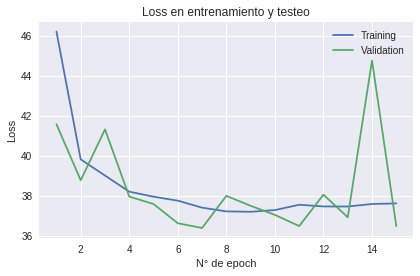

In [261]:
plt.figure(1, figsize=(6,4))
plt.subplot(111)
plt.title("Loss en entrenamiento y testeo")
plt.plot(range(1,len(resultados.history['loss'])+1),resultados.history['loss'], label = "Training")
plt.plot(range(1,len(resultados.history['loss'])+1),resultados.history['val_loss'], label="Validation")
plt.ylabel("Loss")
plt.xlabel("N° de epoch")
plt.legend()
plt.tight_layout()
plt.show();

Según la última figura, la pérdida durante el entrenamiento va disminuyendo gradualmente. En el caso de la pérdida de validación, esta varía en mayor grado en los distintos epochs. Si bien la pérdida durante el epoch = 14 fue muy alta, esto no sucedió de igual manera en el epoch =15. 

### 1.f)

f) Visualice la representación codificada $z$ (variables latentes) de los datos en base a su media $\mu_{z^{(i)}}$. Además genere un histograma de la media y la varianza $\sigma_{z^{(i)}}^2$ de las dos componentes. Comente

In [279]:
!ls

datalab  vae_encoder.h5  vae.h5


In [0]:
from google.colab import files
files.download("vae_encoder.h5")

In [0]:
files.download("vae.h5")

In [0]:
#files.download("prueba.s")

In [98]:
encoder = load_model('vae_encoder.h5')
#vae = load_model('vae.h5')


/usr/local/lib/python3.6/dist-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
z_mean= encoder.predict(X_test, batch_size=batch_size)


In [264]:
z_mean[0]
z_mean[12]

array([ 0.05647828, -0.4969645 ], dtype=float32)

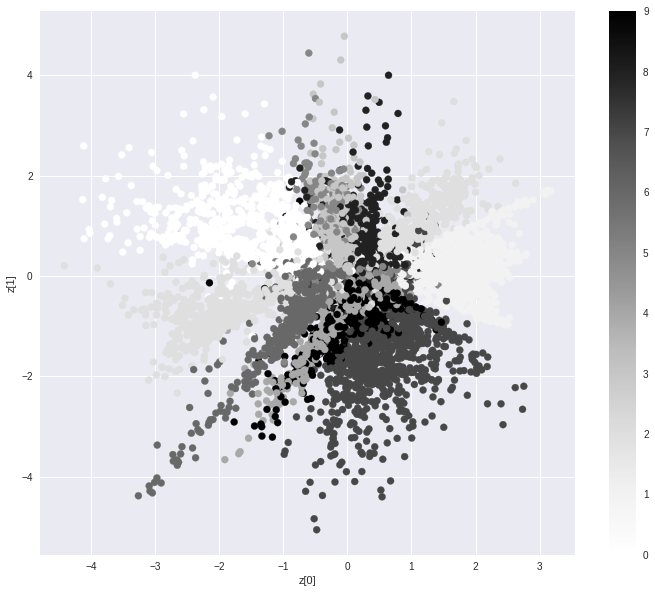

In [265]:
# display a 2D plot of the digit classes in the latent space
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

En la figura anterior podemos ver de manera clara como se distribuyen cada una de las clases dentro del espacio, están en general bastantes separadas unas de otras.

In [266]:
len(z_mean[:, 0])

10000

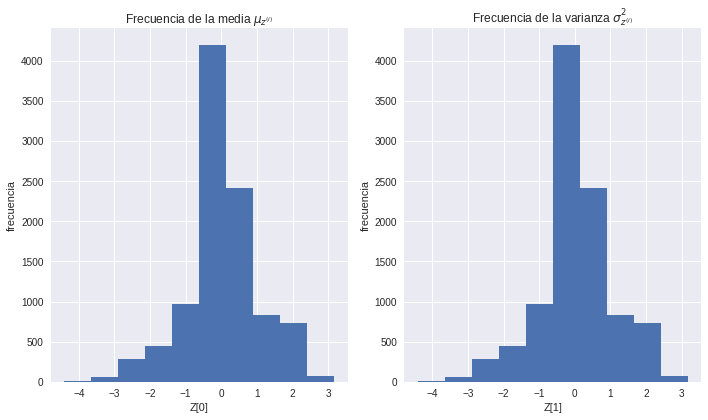

In [267]:
#plot histogram

plt.figure(1, figsize=(10,6))
plt.subplot(121)
plt.hist(z_mean[:, 0])
plt.title("Frecuencia de la media $\mu_{z^{(i)}}$")
plt.ylabel("frecuencia")
plt.xlabel("Z[0]")
#plt.legend()

plt.subplot(122)
plt.title("Frecuencia de la varianza $\sigma_{z^{(i)}}^2$")
plt.hist(z_mean[:, 1])
plt.ylabel("frecuencia")
plt.xlabel("Z[1]")
#plt.legend();

plt.tight_layout()
plt.show();

Podemos apreciar como en general se encuentran normalmente distribuidas  (observar la media en el primer histograma).

### 1.g)

> g) Genere nuevos datos artificialmente a través del espacio de las variables latentes. Para esto deberá generar puntos linealmente separados por debajo de la distribución Normal. Comente qué significa cada eje en la imagen ¿qué sucede más allá en el espacio del 90% confianza de las variables latentes? ¿Qué objetos se generan?

La figura siguiente visualiza la data generada por el decodificador de la red (VAE) entrenada con el dataset MNIST. Aquí, se han muestrado una grilla de valores de dos dimensiones que siguen una distribución específica. 




In [0]:
#GENERATOR
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)


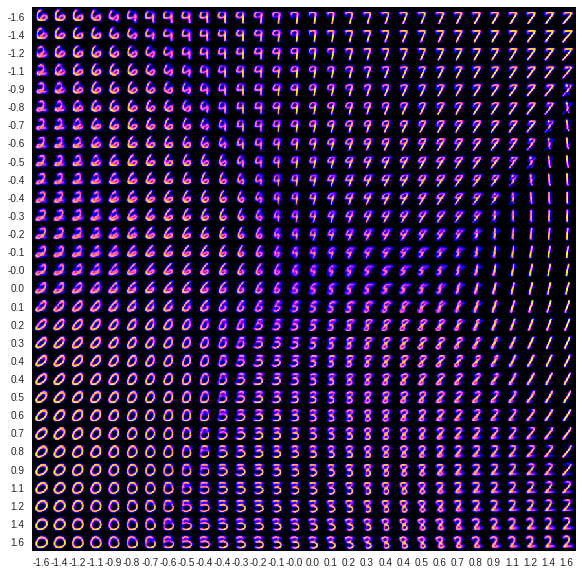

In [269]:
##PLOT
n = 30  # figure with 30x30 images 
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))
#metodo de la transformada inversa
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.grid(False)
plt.show()
#en los extremos del intervalo de confianza
grid = norm.ppf(np.linspace(0.000005, 0.999995, n))

El espacio se encuentra entre los rangos [0.000005, 0.999995], tanto en el eje x como el eje y se divide en 30 valores.Para cada una de estas coordenadas se muestran los dígitos a los que corresponde determinado espacio latente. 

Los resultados de la imagen superior, muestran como se ubican distintos dígitos en diferentes regiones del espacio latente. Es sorprendente como suavemente se transforman de un dígito a otro. Por ejemplo, en ciertas coordenadas el dígito 1 comienza a convertirse en el dígito 7  y éste último se convierte en un 9. Es así como los números más similares se ubican en regiones cercanas del espacio. Números más diferentes visualmente se encontraran en regiones del espacio más separadas. 



A continuación se mostrará en detalle pequeñas secciones del espacio. Se comprobará como solo un dígito se puede encontrar en esos valores:

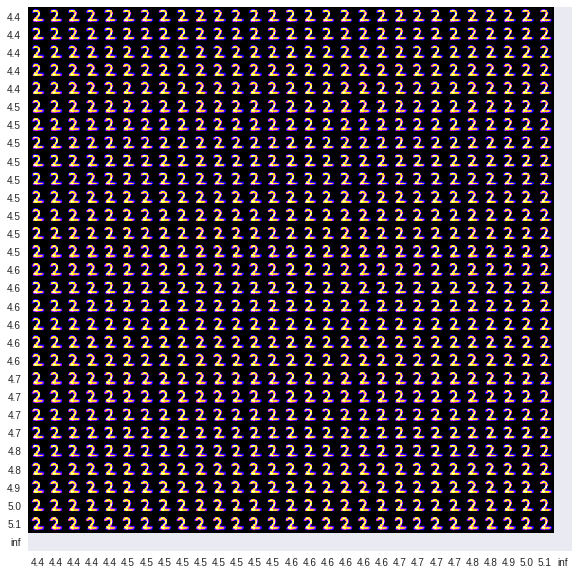

In [270]:
##PLOT
n = 30  # figure with 15x15 images 
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))
#metodo de la transformada inversa
grid_x = norm.ppf(np.linspace(0.999995, 1, n))
grid_y = norm.ppf(np.linspace(0.999995, 1, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.grid(False)
plt.show()
#en los extremos del intervalo de confianza
#grid = norm.ppf(np.linspace(0.000005, 0.999995, n))

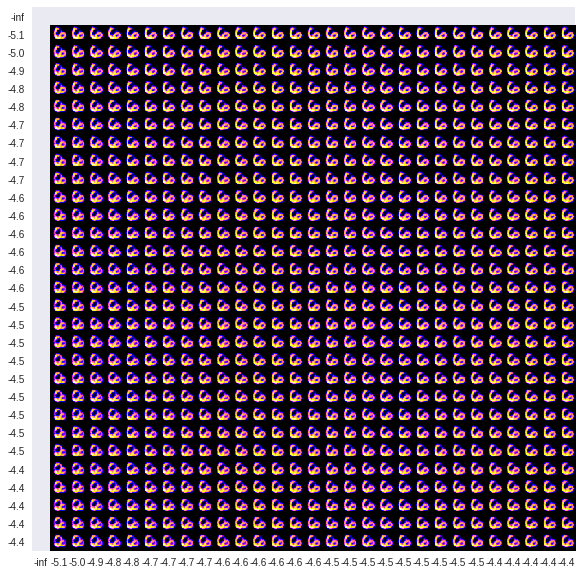

In [271]:
##PLOT
n = 30  # figure with 15x15 images 
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))
#metodo de la transformada inversa
grid_x = norm.ppf(np.linspace(0,0.000005, n))
grid_y = norm.ppf(np.linspace(0,0.000005, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.grid(False)
plt.show()
#en los extremos del intervalo de confianza
#grid = norm.ppf(np.linspace(0.000005, 0.999995, n))

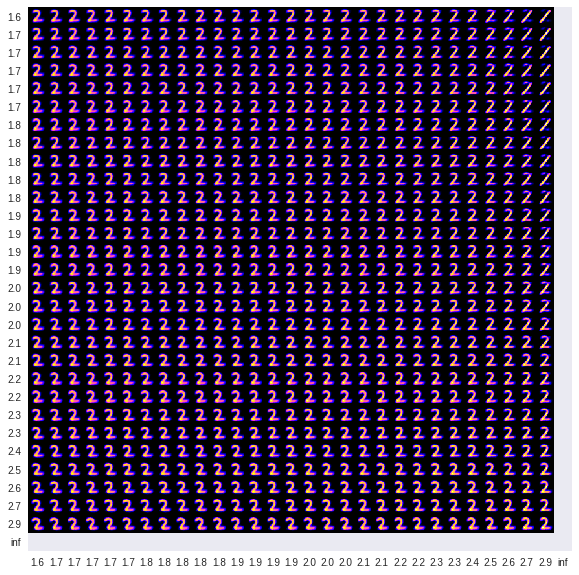

In [272]:
##PLOT
n = 30  # figure with 15x15 images 
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))
#metodo de la transformada inversa
grid_x = norm.ppf(np.linspace(0.95, 1, n))
grid_y = norm.ppf(np.linspace(0.95,1, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.grid(False)
plt.show()


In [0]:
grid = norm.ppf(np.linspace(0.000005, 0.999995, n))

In [274]:
grid

array([-4.41717341, -1.81858461, -1.48350739, -1.26212313, -1.08964555,
       -0.94465676, -0.81722656, -0.7018643 , -0.59517183, -0.49486779,
       -0.39931885, -0.3072894 , -0.21779617, -0.13001728, -0.04323076,
        0.04323076,  0.13001728,  0.21779617,  0.3072894 ,  0.39931885,
        0.49486779,  0.59517183,  0.7018643 ,  0.81722656,  0.94465676,
        1.08964555,  1.26212313,  1.48350739,  1.81858461,  4.41717341])

### 1.h)

> h) ¿Qué pasa al cambiar la distribución latente de los datos $z$? Comente sobre alguna distribución elegida diferente a la Normal y muestre sobre el cómo debiera ser implementada.

Antes de continuar, es necesario hacer un análisis primero: La distribución normal (z), es una distribución continua que está presente en distintos procesos naturales. Que sea "continua" significa que entre dos pares de valores podemos (en teoría) encontrar otro valor. Un ejemplo de una distribución normal es la frecuencia de la altura de los hombres en norteamerica. 

Para ver cómo se obtienen resultados diferentes cambiando la distribución latente, se utilizará una distribución binomial acorde a https://www.tensorflow.org/api_docs/python/tf/keras/backend/random_binomial. Una distribución binomial es muy diferente a una distribución normal o gaussiana, aunque si la muestra es lo suficientemente grande las formas podrían ser bastantes similares. La gran diferencia de una distribución binomial con una gaussiana, es que la primera no es continua, por lo tanto entre dos pares de valores no necesariamente encontraremos otro valor. 

Más información sobre las diferencias entre las distribuciones normal y guassiana se pueden encontrar en: https://www.tensorflow.org/api_docs/python/tf/keras/backend/random_binomial

A continuación se impementará una red con distribución binomial:

In [0]:
#### ENCODER
# input image dimensions
original_img_size = (img_rows, img_cols,channel)
# number of convolutional filters to use
filters = 32
# convolution kernel size
num_conv = 3
latent_dim = 2
intermediate_dim = 128

x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2) #hasta aqui hay 3 bloques convolucionales
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_mean = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)


In [0]:
### DECODER

shape_before_flattening = K.int_shape(conv_3)[1:]
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')


**Se reemplaza la distribución normal por la binomial en esta sección: **

In [25]:

def sampling(args):
    #epsilon_std = 1.0
    z_mean, z_log_var = args
    epsilon = K.random_binomial(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(z_log_var) * epsilon
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)
vae.summary()





__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 28, 28, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_5[0][0]                   
__________________________________________________________________________________________________
flatten_3 

In [26]:
### 1.D

# Compute VAE loss
#choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel* choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 28, 28, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_5[0][0]                   
__________________________________________________________________________________________________
flatten_3 

In [27]:
### 1.E

batch_size = 128
epochs =  15 # o 15
vae.compile(optimizer='rmsprop', metrics=['acc'])
resultados = vae.fit(X_train,epochs=epochs, batch_size=batch_size,validation_data=(X_test, None))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Output "conv2d_transpose_6" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_6" during training.
  after removing the cwd from sys.path.


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 417s 7ms/step - loss: 42.0397 - val_loss: 35.7228
Epoch 2/15
60000/60000 [==============================] - 414s 7ms/step - loss: 35.1682 - val_loss: 35.1843
Epoch 3/15
60000/60000 [==============================] - 410s 7ms/step - loss: 34.2682 - val_loss: 33.7035
Epoch 4/15
60000/60000 [==============================] - 409s 7ms/step - loss: 33.7564 - val_loss: 33.7029
Epoch 5/15
60000/60000 [==============================] - 406s 7ms/step - loss: 33.7262 - val_loss: 33.8822
Epoch 6/15
60000/60000 [==============================] - 407s 7ms/step - loss: 33.5878 - val_loss: 35.6099
Epoch 7/15
60000/60000 [==============================] - 401s 7ms/step - loss: 33.5717 - val_loss: 32.9179
Epoch 8/15
60000/60000 [==============================] - 401s 7ms/step - loss: 33.4881 - val_loss: 34.5279
Epoch 9/15
60000/60000 [==============================] - 404s 7ms/step - loss: 33.402

In [0]:
vae.save('vae_binomial_distribution.h5') #se guarda el modelo
encoder.save("vae_binomial_distribution_encoder.h5")

Los resultados obtenidos al cambiar la ditribución son los siguientes:

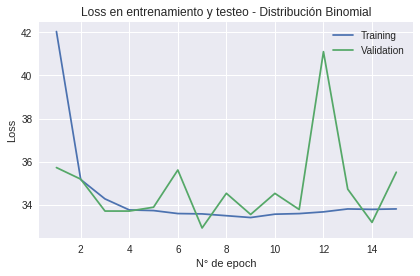

In [29]:
plt.figure(1, figsize=(6,4))
plt.subplot(111)
plt.title("Loss en entrenamiento y testeo - Distribución Binomial")
plt.plot(range(1,len(resultados.history['loss'])+1),resultados.history['loss'], label = "Training")
plt.plot(range(1,len(resultados.history['loss'])+1),resultados.history['val_loss'], label="Validation")
plt.ylabel("Loss")
plt.xlabel("N° de epoch")
plt.legend()
plt.tight_layout()
plt.show();

Acorde a la imagen anterior, la pérdida va disminuyendo gradualmente durante el entrenamiento. En el caso de la validación, la pérdida presenta fluctuaciones entre epochs. 

Al observar este gráfico con respeto al obtenido al usar una distribución normal, se puede encontrar que el rango de valores y (pérdida) en este caso es levemente menor que el de la distribución normal. 

Se deben realizar test estádisticos para determinar si esta variación es significativa y así comprobar los efectos de la distribución binomial.

In [0]:
z_mean= encoder.predict(X_test, batch_size=batch_size)


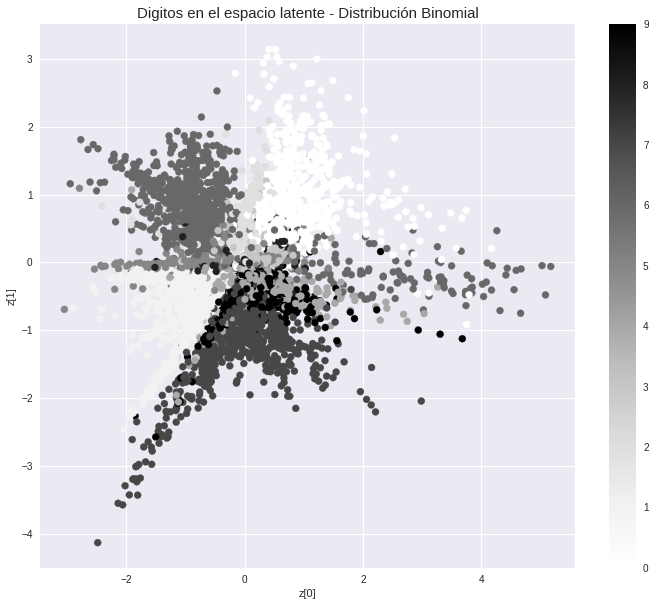

In [33]:
# display a 2D plot of the digit classes in the latent space
plt.figure(figsize=(12, 10))
plt.title("Digitos en el espacio latente - Distribución Binomial", fontsize=15)
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

En la imagen superior podemos ver cómo se ubican los distintos digitos dentro del espacio. Al igual que en la distribución normal, la mayoría de los dígitos se concentran en las coordenadas (0,0), sin embargo la distribución de estos dentro del espacio son diferentes a las obtenidas en  la distribución gaussiana. 

El rango de valores del los eje x e y es similar entre ambas distribuciones. 

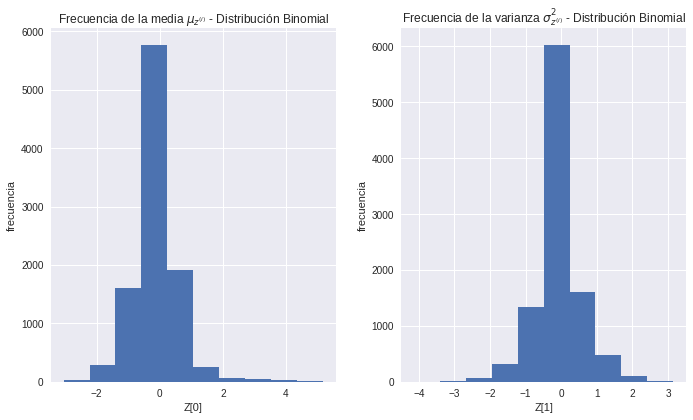

In [35]:
#plot histogram

plt.figure(1, figsize=(10,6))
plt.subplot(121)
plt.hist(z_mean[:, 0])
plt.title("Frecuencia de la media $\mu_{z^{(i)}}$ - Distribución Binomial")
plt.ylabel("frecuencia")
plt.xlabel("Z[0]")
#plt.legend()

plt.subplot(122)
plt.title("Frecuencia de la varianza $\sigma_{z^{(i)}}^2$ - Distribución Binomial")
plt.hist(z_mean[:, 1])
plt.ylabel("frecuencia")
plt.xlabel("Z[1]")
#plt.legend();

plt.tight_layout()
plt.show();

La imagens uperior muestra la frecuencia de la media y la varianza con la distribución utilizada. Estos resultados confirman lo visualizado anteriormente (con las distintas clases de dígitos dentro del espacio)

In [0]:
#GENERATOR
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)


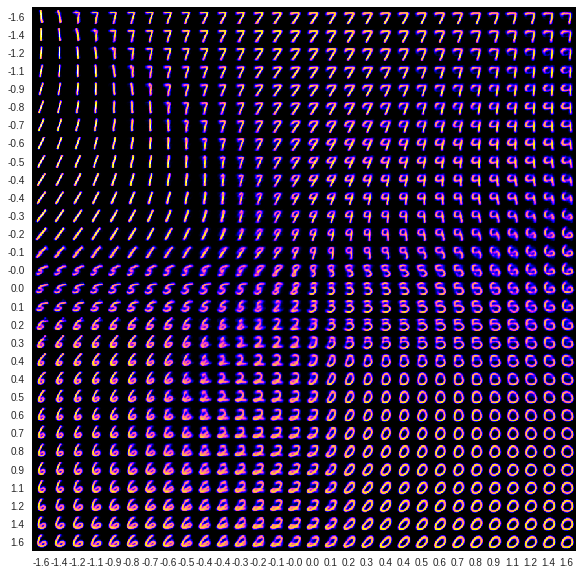

In [37]:
##PLOT
n = 30  # figure with 30x30 images 
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))
#metodo de la transformada inversa
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.grid(False)
plt.show()
#en los extremos del intervalo de confianza
grid = norm.ppf(np.linspace(0.000005, 0.999995, n))

En la imagen superior se puede visualizar distintos digitos generados por la red. Notar como estas figuras tienden a hacer más curvas en comparación a las obtenidas cuando se utilizó una red con una distribución normal. 

Los dígitos se encuentran en distintas regiones del espacio en comparación a las posiciones obtenidas cuando se utilizó una distribución normal. 

Dígitos que tienen características similares son agrupados juntos: Por ejemplo, 6 -> 2 -> 0. 

Es interesante notar como las distintas clases de dígitos se van convirtiendo de un tipo a otro. En nuestra opinión, estas transformaciones no son tan suaves como en el caso anterior. 

### 1.i)

 i) Comente sobre si mejora o empeora el desempeño al aumentar la dimensionalidad de las variables latentes $z$, explique.

A continuación se implementa una red en donde la dimensionalidad de las variables latentes es igual a 5 (Antes este valor era '2').

Antes de continuar, es necesario saber lo siguiente: Autoencoders (o al menos su componente encoder) son en general algoritmos de compresion. Esto signfica que aproximan data 'real' en un conjunto abstracto menor de características. ¿Qué sucede cuando se introduce una dimensionalidad de caracteríticas más alta? La respuesta es que nos ayudaran a expresar la data original de manera más escueta. 

Más información sobre los efectos de la dimensionalidad de las variables latentes: https://stats.stackexchange.com/questions/327966/variational-autoencoder-%E2%88%92-dimension-of-the-latent-space 

In [0]:
#### ENCODER
# input image dimensions
original_img_size = (img_rows, img_cols,channel)
# number of convolutional filters to use
filters = 32
# convolution kernel size
num_conv = 3
latent_dim = 5
intermediate_dim = 128

x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2) #hasta aqui hay 3 bloques convolucionales
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_mean = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)


In [0]:
### DECODER

shape_before_flattening = K.int_shape(conv_3)[1:]
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')


In [16]:
def sampling(args):
    epsilon_std = 1.0
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 

In [17]:
### 1.D

# Compute VAE loss
#choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel* choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 

In [18]:
### 1.E

batch_size = 128
epochs =  15 # o 15
vae.compile(optimizer='rmsprop', metrics=['acc'])
resultados = vae.fit(X_train,epochs=epochs, batch_size=batch_size,validation_data=(X_test, None))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Output "conv2d_transpose_3" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_3" during training.
  after removing the cwd from sys.path.


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 387s 6ms/step - loss: 39.4409 - val_loss: 32.4206
Epoch 2/15
60000/60000 [==============================] - 387s 6ms/step - loss: 31.4363 - val_loss: 29.4879
Epoch 3/15
60000/60000 [==============================] - 385s 6ms/step - loss: 30.4659 - val_loss: 34.7416
Epoch 4/15
60000/60000 [==============================] - 382s 6ms/step - loss: 30.3266 - val_loss: 28.9305
Epoch 5/15
60000/60000 [==============================] - 382s 6ms/step - loss: 29.6920 - val_loss: 27.5649
Epoch 6/15
60000/60000 [==============================] - 382s 6ms/step - loss: 29.5262 - val_loss: 30.7978
Epoch 7/15
60000/60000 [==============================] - 381s 6ms/step - loss: 29.2077 - val_loss: 28.2140
Epoch 8/15
60000/60000 [==============================] - 382s 6ms/step - loss: 28.9836 - val_loss: 27.8733
Epoch 9/15
60000/60000 [==============================] - 382s 6ms/step - loss: 29.046

In [0]:
vae.save('vae_more_latent_dimensions.h5') #se guarda el modelo
encoder.save("vae_more_latent_dimensions_encoder.h5")

Los resultados de aumentar la dimensionalidad de las variables latentes se puede encontrar en la siguiente figura:

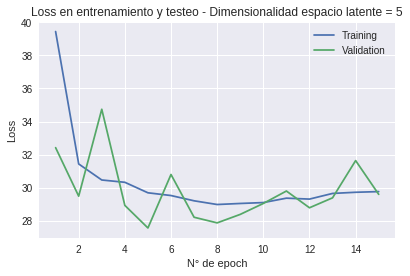

In [20]:
plt.figure(1, figsize=(6,4))
plt.subplot(111)
plt.title("Loss en entrenamiento y testeo - Dimensionalidad espacio latente = 5")
plt.plot(range(1,len(resultados.history['loss'])+1),resultados.history['loss'], label = "Training")
plt.plot(range(1,len(resultados.history['loss'])+1),resultados.history['val_loss'], label="Validation")
plt.ylabel("Loss")
plt.xlabel("N° de epoch")
plt.legend()
plt.tight_layout()
plt.show();

En esta podemos verificar que la pérdida durante el entrenamiento disminuye epoch a epoch y que la pérdida de la validación fluctua en el tiempo. El comportamiento no es muy distinto al que se obtiene con dimensionalidad = 2.

In [0]:
z_mean= encoder.predict(X_test, batch_size=batch_size)


A cotninuación se mostrarán las distintas clases de dígito dentro del espacio. 

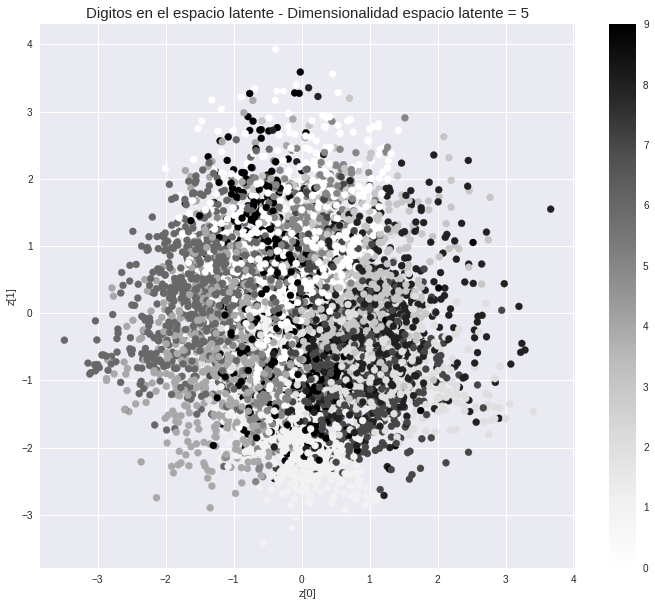

In [22]:
# display a 2D plot of the digit classes in the latent space
plt.figure(figsize=(12, 10))
plt.title("Digitos en el espacio latente - Dimensionalidad espacio latente = 5", fontsize=15)
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

A diferencia de los casos anteriores, podemos ver que la red no logra separar los distintos números eficientemente.En este caso, si bien se pueden ditintir algunos grupos grandes de números, estos en general se encuentran muy distribuidos dentro del espacio y tienden a sobreponerse sobre otros. 

Los resultados no son tan buenos como en los casos anteriores.

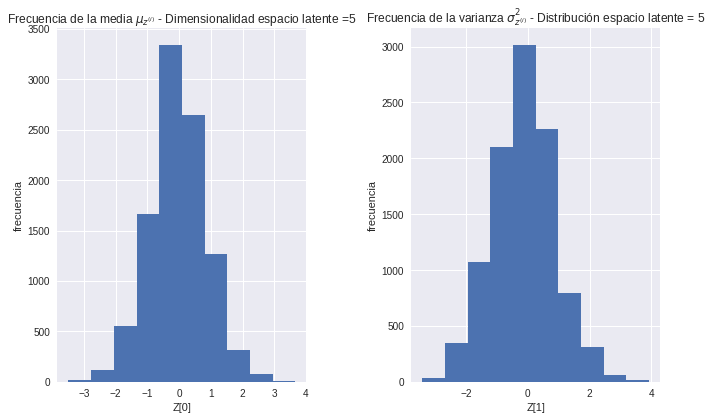

In [23]:
#plot histogram

plt.figure(1, figsize=(10,6))
plt.subplot(121)
plt.hist(z_mean[:, 0])
plt.title("Frecuencia de la media $\mu_{z^{(i)}}$ - Dimensionalidad espacio latente =5")
plt.ylabel("frecuencia")
plt.xlabel("Z[0]")
#plt.legend()

plt.subplot(122)
plt.title("Frecuencia de la varianza $\sigma_{z^{(i)}}^2$ - Distribución espacio latente = 5")
plt.hist(z_mean[:, 1])
plt.ylabel("frecuencia")
plt.xlabel("Z[1]")
#plt.legend();

plt.tight_layout()
plt.show();

En la imagen anterior se puede apreciar las frecuencias de la media y de la varianza para este caso. Las visualizaciones superior pretenden explicar lo que ocurre al graficar las distintas clases de dígitos dentro del espacio. 

### 1.j)

 j) Vea qué sucede al cambiar algún aspectro estructural de la red (en su arquitectura). Recuerde que la estructura del *decoder* debe ser análoga a la del *encoder.  
 

Una nueva red será creada en esta oportunidad. En esta ocasión, el encoder y decoder estará compuesto por 5 capas convolucionales (En el caso anterior se utilizaban solo 3). Además, el encoder tiene Dropout para reducir la cantidad de parámetros y como una forma de prevenir overfitting. 

In [0]:
#### ENCODER
# input image dimensions
original_img_size = (img_rows, img_cols,channel)
# number of convolutional filters to use
filters = 32
# convolution kernel size
num_conv = 3
latent_dim = 2
intermediate_dim = 128

x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_1_drop = Dropout(0.2)(conv_1)
conv_1_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1_drop)
conv_1_1_drop = Dropout(0.2)(conv_1_1)
conv_1_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1_1_drop)
conv_1_2_drop = Dropout(0.2)(conv_1_2)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1_2_drop)
conv_2_drop = Dropout(0.2)(conv_2)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2_drop) #hasta aqui hay 3 bloques convolucionales
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_mean = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)


In [0]:
### DECODER

shape_before_flattening = K.int_shape(conv_3)[1:]
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_1_1 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_deconv_1_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')


In [27]:
def sampling(args):
    epsilon_std = 1.0
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_1_1_decoded = decoder_deconv_1_1(deconv_1_decoded)
deconv_1_2_decoded = decoder_deconv_1_2(deconv_1_1_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 28, 28, 32)   320         input_6[0][0]                    
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 28, 28, 32)   0           conv2d_22[0][0]                  
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 28, 28, 32)   9248        dropout_13[0][0]                 
__________________________________________________________________________________________________
dropout_14

In [28]:
### 1.D

# Compute VAE loss
#choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel* choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 28, 28, 32)   320         input_6[0][0]                    
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 28, 28, 32)   0           conv2d_22[0][0]                  
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 28, 28, 32)   9248        dropout_13[0][0]                 
__________________________________________________________________________________________________
dropout_14

In [30]:
### 1.E

batch_size = 128
epochs =  10 # o 15
vae.compile(optimizer='rmsprop', metrics=['acc'])
resultados = vae.fit(X_train,epochs=epochs, batch_size=batch_size,validation_data=(X_test, None))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Output "conv2d_transpose_15" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_15" during training.
  after removing the cwd from sys.path.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 899s 15ms/step - loss: 44.3494 - val_loss: 42.1358
Epoch 2/10
60000/60000 [==============================] - 900s 15ms/step - loss: 39.0426 - val_loss: 37.7003
Epoch 3/10
60000/60000 [==============================] - 898s 15ms/step - loss: 37.0863 - val_loss: 36.2758
Epoch 4/10
60000/60000 [==============================] - 897s 15ms/step - loss: 35.9591 - val_loss: 35.5407
Epoch 5/10
60000/60000 [==============================] - 897s 15ms/step - loss: 35.2846 - val_loss: 35.8023
Epoch 6/10
60000/60000 [==============================] - 898s 15ms/step - loss: 34.8077 - val_loss: 34.9209
Epoch 7/10
60000/60000 [==============================] - 897s 15ms/step - loss: 34.4858 - val_loss: 34.3692
Epoch 8/10
60000/60000 [==============================] - 899s 15ms/step - loss: 34.2144 - val_loss: 34.2417
Epoch 9/10
60000/60000 [==============================] - 902s 15ms/step - los

Dado que el tiempo por epoch era el doble que en ocasiones anteriores, solo se realizaron 10 epochs.  Para mayor información, observar resultados superiores.

In [0]:
vae.save('vae_arquitectura_cambiada.h5') #se guarda el modelo
encoder.save("vae_arquitectura_cambiada_encoder.h5")

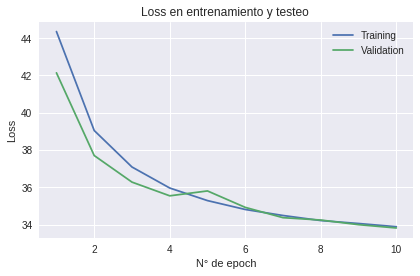

In [39]:
plt.figure(1, figsize=(6,4))
plt.subplot(111)
plt.title("Loss en entrenamiento y testeo ")
plt.plot(range(1,len(resultados.history['loss'])+1),resultados.history['loss'], label = "Training")
plt.plot(range(1,len(resultados.history['loss'])+1),resultados.history['val_loss'], label="Validation")
plt.ylabel("Loss")
plt.xlabel("N° de epoch")
plt.legend()
plt.tight_layout()
plt.show();

En la figura superior se puede ver como la pérdida durante el entrenamiento  y validación disminuye gradualmente al aumentar el número de epochs. A diferencia de casos anteriores, en la imagen superior se puede apreciar que la pérdida de validación no se ve expuesta a fluctuaciones grandes (como lo que ocurría en la otra arquitectura).

Si bien con la arquitectura probada en esta pregunta el tiempo de entrenamiento se duplica, todo parece indicar menores pérdidas según el número de epochs. 

In [0]:
z_mean= encoder.predict(X_test, batch_size=batch_size)


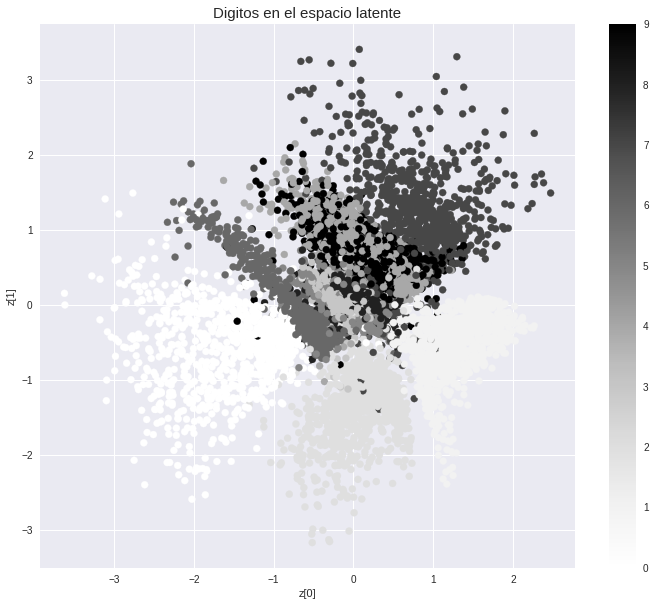

In [38]:
# display a 2D plot of the digit classes in the latent space
plt.figure(figsize=(12, 10))
plt.title("Digitos en el espacio latente", fontsize=15)
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

En la imagens superior se  aprecia como distintos dígitos se encuentran ubicados en diferentes regiones del espacio. Cada una de estas clases se encuentra notoriamente separada del resto. 

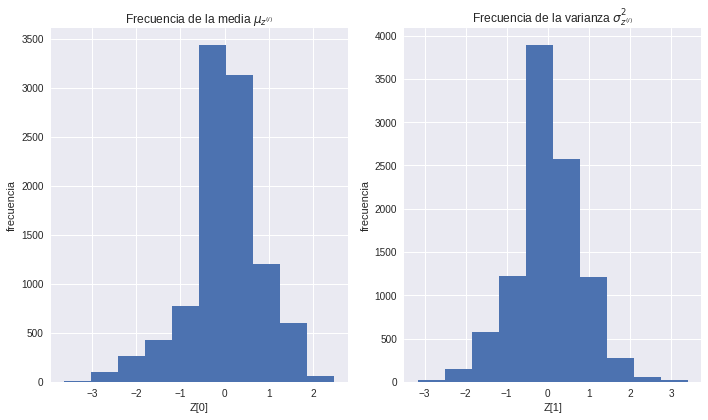

In [50]:
#plot histogram

plt.figure(1, figsize=(10,6))
plt.subplot(121)
plt.hist(z_mean[:, 0])
plt.title("Frecuencia de la media $\mu_{z^{(i)}}$")
plt.ylabel("frecuencia")
plt.xlabel("Z[0]")
#plt.legend()

plt.subplot(122)
plt.title("Frecuencia de la varianza $\sigma_{z^{(i)}}^2$")
plt.hist(z_mean[:, 1])
plt.ylabel("frecuencia")
plt.xlabel("Z[1]")
#plt.legend();

plt.tight_layout()
plt.show();

En la figura superior se muestran las frecuencias de la media y la varianza. 

A continuación se generarán distintos dígitos:

In [0]:
#GENERATOR
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_1_1_decoded = decoder_deconv_1_1(_deconv_1_decoded)
#_deconv_1_2_decoded = decoder_deconv_1_2(_deconv_1_1_decoded)
_deconv_1_decoded = decoder_deconv_1_2(_deconv_1_1_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)


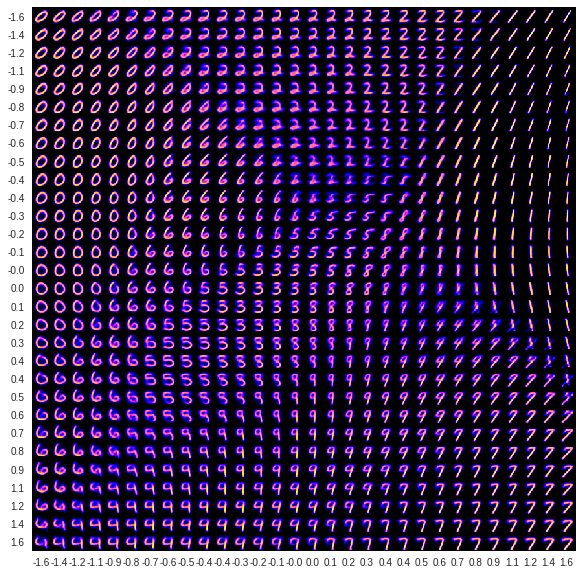

In [49]:
##PLOT
n = 30  # figure with 30x30 images 
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))
#metodo de la transformada inversa
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.grid(False)
plt.show()
#en los extremos del intervalo de confianza
grid = norm.ppf(np.linspace(0.000005, 0.999995, n))

En la  figura superior se puede apreciar que la arquitectura utilizada funciona. Los dígitos generados tienden a ser en algunos sectores del espacio un poco más curvos que lo general. 

## 1.2 *Generative Adversarial Networks* (GAN) [[4]](#refs)



Las GAN son un enfoque distinto de modelo generativo. A pesar de que tiene dos redes conectadas, las tareas que realiza cada una de ella son distintas. Se trata de un modelo adversario en que una red *compite* con la otra. Por un lado se tiene la red discriminadora $D$ que intenta disernir si un dato proviene de los datos reales o fue un dato generado artificialmente. Por otro lado se tiene la red generadora $G$ que intenta generar datos artificialmente de manera que la red discriminadora se confunda, es decir, sea lo más similar a los datos reales. 

<img src="https://oshearesearch.com/wp-content/uploads/2016/07/mnist_gan.png" title="VAE" width="60%" />


El enfoque optimizador de los parámetros de la red neuronal es para $D$ el de maximizar la probabilidad de los datos que provienen de la distribución original minimizando la probabilidad de los datos que provienen del modelo generativo. Mientras que para $G$ es el de maximizar la probabilidad de que $D$ asigne un dato de $G$ como real, o bien, minimizar la probabilidad de que $D$ asigne un dato de $G$ como corrupto.

$$
min_G \ max_G = E_{x\sim p_{data}(x) }[logD(x)] + E_{z\sim p_z(z)}[log(1-D(G(z))]
$$

Ésto tiene un óptimo teórico que es cuando $p_g = p_{data}$, es decir, cuando el *generador* $G$ logra imitar la distribución de probabilidad de los datos.



### Importar Librerías

In [0]:
from keras.models import Model,Sequential
from keras.layers import LeakyReLU,Conv2D,Dropout,Flatten,Dense
from keras.layers import BatchNormalization,Reshape,UpSampling2D,Conv2DTranspose,Activation
from keras.optimizers import RMSprop

from keras.models import Model,Sequential
from keras.layers import LeakyReLU,Conv2D,Dropout,Flatten,Dense
from keras.layers import BatchNormalization,Reshape,UpSampling2D,Conv2DTranspose,Activation


### 1.2.a)

> a) Defina al *discriminador* de la GAN como el que se muestra en el código, de 3 bloque convolucionales y una tanda *fully conected*, con los Dropout para evitar *overfitting*. Describa la arquitectura utilizada y cuál es la función de activación seleccionada.

In [19]:

## Discriminator
D = Sequential()
depth = 64
dropout = 0.4
input_shape = (img_rows, img_cols, channel)
D.add(Conv2D(depth*1, (5,5), strides=2, input_shape=input_shape,padding='same', activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*2, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*4, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Flatten())
D.add(Dense(1024,activation=LeakyReLU(alpha=0.2)))
D.add(Dense(1,activation='sigmoid'))
D.summary()

/usr/local/lib/python3.6/dist-packages/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
__________

En esta arquitectura se encuentran 3 bloques convolucionales con una fully connected. Además, se utiliza dropout en capas internas con valor de 0.4 (neuronas que se 'apagan'). 

El modelo es secuencial y el padding tiene el atributo "same", lo que significa que la salida será del mismo largo que la original. 

Este modelo tiene más de 5 millones de parámetros entrenables. 

Las capas internas ocupan la función de activación: LeakyReLU.  Esta función  permite pequeños y positivos gradientes cuando una unidad no es activa. Está dada por la siguiente ecuación: 

<div align="center"><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/01d5ac8361d825fe42fbde1ed42047aeac1e6160"> </div>

En la siguiente figura se puede apreciar como se comporta LeakyRelu, ReLU y Randominized LeakyReLU.

<div align="center"><img src="https://i.stack.imgur.com/1BX7l.png"></div>

Para términar, notar que en esta arquitectura la última capa tiene función de activación sigmoid. 



### 1.2.b)

> b) Defina al *generador* de la GAN como el que se muestra en el código, con una tanda *fully conected* y 3 bloque convolucionales transpuesta además de agregar *BatchNormalization* entre ellas para tener un aprendizaje más estable. Describa la arquitectura utilizada (siendo del tipo *fully convolutional* puesto que la salida es un arreglo n-dimensional) y el porqué la función de activación de la salida es *sigmoidal*.

In [20]:

## Generator
G = Sequential()
dim = 14
input_dim= 2 #para que sea similar al vAE
G.add(Dense(128, input_dim=input_dim))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Dense(dim*dim*depth))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Reshape((dim, dim, depth)))
G.add(Conv2DTranspose(int(depth/2), (3,3), padding='same',strides=(2,2)))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Conv2DTranspose(int(depth/2), (3,3), padding='same'))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Conv2DTranspose(channel, (3,3), padding='same')) 
G.add(Activation('sigmoid')) 
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               384       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 12544)             1618176   
_________________________________________________________________
batch_normalization_2 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_2 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 64)        0         
__________

Fully convolutional indica que la red está compuesta de capas neuronales sin una capa fully-connected. Aprender con una CNN con capas fully connected es tan 'fácil' de aprender como con una fully convolutional. La gran diferencia es que la red fully convolutional aprende filtro en todas partes, incluso la capa de decisión al final de la red sigue siendo filtros. 

Una red fully convolutional intenta aprender representaciones y tomar decisiones basadas en entradas del espacio local. Agregar una capa fully connected permite que la red aprenda algo utilizando información global donde la disposición espacial de la entrada se cae y no es necesario aplicarla.

Para mayor información: https://www.quora.com/How-is-Fully-Convolutional-Network-FCN-different-from-the-original-Convolutional-Neural-Network-CNN 

Por otro lado, Batch Normalization es una técnica para mejorar el rendimiento y estabilidad de redes neuronales. Es usada para normalizar las capas de entrada adjustando y escalando las activaciones. El proceso está dado por lo siguiente:

<div align="center"><img src="https://cdn-images-1.medium.com/max/800/1*Hiq-rLFGDpESpr8QNsJ1jg.png"></div>

El paper donde fue expuesta esta técnica por primera vez puede ser encontrado en: https://arxiv.org/pdf/1502.03167v3.pdf

En https://github.com/RichardKelley/GANs/blob/master/simple_gan_mnist.ipynb se realiza una GAN y para ello se hace un gran número de comparaciones. En ella se demostró que LeakyReLU era una buena alternativa para las capas interiores y que sigmoid funcionaba mejor para la capa de salida. Se intentó tanh como capa de salida pero los resultados fueron inferiores a los obtenidos por sigmoid. 

Características y mayor información sobre cómo funciona Sigmoid, puede ser encontrada en: https://www.quora.com/What-is-the-sigmoid-function-and-what-is-its-use-in-machine-learnings-neural-networks-How-about-the-sigmoid-derivative-function 

### 1.c)

> c) Conecte los modelos a través del enfoque adversario, será necesario definir dos modelos debido a que el entrenamiento es iterativo, primero se entrena el discriminador el generador fijo, luego se entrena el generador con el discriminador fijo y así. 


In [0]:
from keras.optimizers import Adam
from keras.optimizers import RMSprop
## Discriminator model (police)
#optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
optimizer = Adam(lr = 0.001)
DM = Sequential()
DM.add(D)
DM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
## Adversarial model (Generator->Discriminator)
D.trainable=False #set the discriminator freeze  (fixed params)
#optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
#optimizer =ADAM
optimizer = Adam(lr = 0.001)
AM = Sequential()
AM.add(G)
AM.add(D)
AM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])


**¡Atención!** En esta sección es donde se presenta el cambio más significativo de la arquitectura. 

Siendo sinceros, realizar esta pregunta fue una real pesadilla. La comunidad científica es clara en afirmar que las GAN son complicadas y aún es  necesaria mucha investigación al respecto. El código entregado en esta sección utilizaba RMSprop como optimizador, con learning rate de 0.0008 para el discriminador y de 0.0004 para el generador. Además, como regularizador se utilizaba learning rate decay en un factor de 3e-8 y clipvalue = 1.0. 

Clipvalue es una funcionalidad de keras que permite que los gradientes no excedan cierto monto, en este caso serán recortados entre -1.0 y 1.0 (Fuente: https://keras.io/optimizers/)

Continuando con la historia, utilizar la arquitectura dada por el ayudante fue tediosa. Durante muchas ocasiones, tanto el discriminador como el generador se estancaban. Loss y acc para cada uno de ellos no cambiaban y esto sucedía ya en el segundo epoch. 

Milagrosamente, en uno de los intentos la red logró funcionar pero el máximo de epochs realizados en esa oportunidad fue 100. El mejor resultado fue el siguiente: 

<div align="center"><img src="https://vvcap.com/img/249ugUqCg.png"></div>
 Lamentablemente, al momento de intentar ejecutar la red por segunda oportunidad, esta se volvió a estancar (y sí! reiniciamos el kernel y nos aseguramos de que los pesos no estuvieran guardados). Así que decidimos hacer un cambio de planes y cambiar todo lo posible para conseguir mejores resultados. 
 
 **Nueva Arquitectura:**  Si bien en el comienzo intentamos distintas arquitecturas diferentes (cambios de learning rate, nuevos optimizadores, etc), descubrimos que la arquitectura que funcionaba para este caso era más simple que lo que imaginabamos. Al código original entregado por el ayudante, solo le era necesario reemplazar el optimizador RMSprop con el de Adam. El decaimiento exponencial del learning rate fue eliminado al igual que el clip value.  **Una vez realizado lo anterior, logramos que la red no se estanque.**
 
 
 Los resultados y modificacionales adicionales serán explicadas en las siguientes preguntas. 

Material extra que apoya cambios en la arquitectura: https://arxiv.org/abs/1606.03498 , https://towardsdatascience.com/only-numpy-implementing-gan-general-adversarial-networks-and-adam-optimizer-using-numpy-with-2a7e4e032021

### 1.d)

> d) Entrene el modelo definido con el enfoque iterativo como se nombró, para ésto utilice la función que se presenta que lo realiza de manera manual. Grafique la pérdida *loss* de cada red (el generador y el discriminador/adversario) a través de los pasos de actualización de los pesos ¿Cómo se espera que sean estas curvas de aprendizaje?

In [23]:

def train_on_steps(X_train,DM,AM,G,steps,batch_size):
    history = {"d":[],"g":[]}
    for e in range(train_steps):
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=batch_size),:,:,:] #sample images from real data
        noise_gen = np.random.uniform(-1,1,size=[batch_size,input_dim]) #sample image from generated data
        generated_images = G.predict(noise_gen) #fake images
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        #create labels
        y = np.ones([2*batch_size,1])
        y[batch_size:,:] = 0
        d_loss  = DM.train_on_batch(X,y)
        history["d"].append(d_loss)
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(-1,1,size=[batch_size,input_dim])
        y = np.ones([batch_size, 1])
        g_loss = AM.train_on_batch(noise_tr, y)
        history["g"].append(g_loss)
        log_mesg = "%d: [D loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [G loss: %f, acc: %f]" % (log_mesg, g_loss[0], g_loss[1])
        print(log_mesg)
    return history
train_steps = 5000 #or few if  you want
hist = train_on_steps(X_train,DM,AM,G,train_steps,64)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [D loss: 0.699225, acc: 0.375000]  [G loss: 1.144718, acc: 0.000000]
1: [D loss: 0.597419, acc: 0.531250]  [G loss: 2.470095, acc: 0.000000]
2: [D loss: 0.441263, acc: 0.742188]  [G loss: 0.707649, acc: 0.500000]
3: [D loss: 0.574708, acc: 0.601562]  [G loss: 5.710133, acc: 0.000000]
4: [D loss: 0.297915, acc: 0.859375]  [G loss: 6.942183, acc: 0.000000]
5: [D loss: 0.305923, acc: 0.875000]  [G loss: 4.899388, acc: 0.000000]
6: [D loss: 0.129583, acc: 0.945312]  [G loss: 2.256420, acc: 0.000000]
7: [D loss: 0.104859, acc: 0.992188]  [G loss: 1.166301, acc: 0.125000]
8: [D loss: 0.173635, acc: 0.929688]  [G loss: 2.299778, acc: 0.000000]
9: [D loss: 0.042188, acc: 1.000000]  [G loss: 3.952468, acc: 0.000000]
10: [D loss: 0.018030, acc: 0.992188]  [G loss: 5.284739, acc: 0.000000]
11: [D loss: 0.015539, acc: 1.000000]  [G loss: 5.796071, acc: 0.000000]
12: [D loss: 0.012690, acc: 1.000000]  [G loss: 5.792898, acc: 0.000000]
13: [D loss: 0.050914, acc: 0.976562]  [G loss: 5.165164, acc

In [0]:
loss_discriminador = [] 
acc_discriminador = [] 
loss_generador = []
acc_generador = []

for loss, acc in hist['d']:
  loss_discriminador.append(loss)
  acc_discriminador.append(acc)

for loss, acc in hist['g']:
  loss_generador.append(loss)
  acc_generador.append(acc)



Notar que en este caso, un batch de 64 fue utilizado. El loss y accuracy obtenido para esta arquitectura durante 5000 epochs se muestra a continuación: 

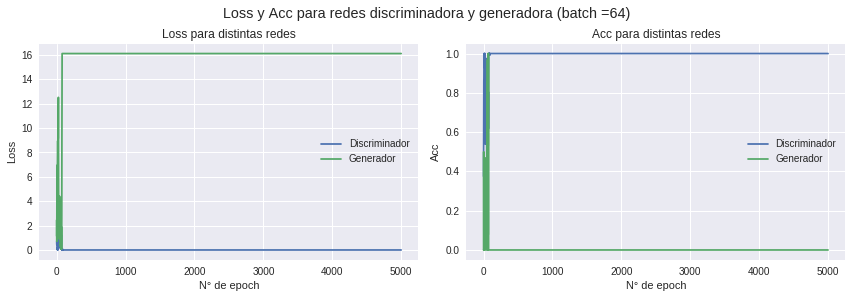

In [25]:
plt.figure(6, figsize=(12,4))
plt.suptitle("Loss y Acc para redes discriminadora y generadora (batch =64)", y=1.03)
plt.subplot(121)
plt.title("Loss para distintas redes")
plt.plot(loss_discriminador, label = "Discriminador")
plt.plot(loss_generador, label="Generador")
plt.ylabel("Loss")
plt.xlabel("N° de epoch")
plt.legend()
plt.tight_layout()
plt.subplot(122)
plt.title("Acc para distintas redes")
plt.plot(acc_discriminador, label = "Discriminador")
plt.plot(acc_generador, label="Generador")
plt.ylabel("Acc")
plt.xlabel("N° de epoch")
plt.legend()
plt.tight_layout()
plt.show();

**¿Cómo debería ser el loss para redes de este tipo?** Como decíamos anteriormente, en la comunidad científica existen distintos intentos de conseguir resultados utilizando GAN. 

En [http://www.rricard.me/machine/learning/generative/adversarial/networks/keras/tensorflow/2017/04/05/gans-part2.html] implementaron una red utilizando Keras, y la forma de la disminución de loss durante el entrenamiento está dado por la siguiente figura: 

<div align="center"><img src="http://www.rricard.me/public/images/gans/output_14_1.png"></div>

En https://www.wouterbulten.nl/blog/tech/getting-started-with-gans-2-colorful-mnist/, realizaron otra de estas redes para resolver el problema del MNIST y el loss y accuracy obtenido por ellos fue el siguiente: 

<div align="center"><img src="https://d33wubrfki0l68.cloudfront.net/8ec08ca98bd2dc4baefc365bfca6f49dffe131ce/39c48/assets/images/gan-color/mnistcolor_20_0.png"></div>

La variación del loss y el accuracy durante el entrenamiento dependerán de la arquitectura utilizada y estarán vinculados con los resultados finales. 

Lo que debería suceder es que ambas partes juguen entre sí, cada una aprendiendo a ser mejor que la otra. En algunas fases el generador o el discriminador debería disminuir su pérdida en relación con una ganancia de pérdida en el otro lado. 

Lo importante de estos gráficos es asegurarse que la red no converja a cero demasiado rápido, de lo contrario, eso significa que lograron engañarse unos a otros. 


### 1.2.e)

> e) Genere nuevos datos artificialmente a través del modelo generador *G* ya entrenado, para esto inicialice aleatoriamente el espacio oculto de dimensiones del generador a través de una distribución Uniforme entre -1 y 1, al igual como fue entrenado. Comente sobre las imágenes generadas y compare con lo realizado con el VAE, en temas de calidad visual y en tiempos de ejecución.

Los resultados para esta arquitectura fueron los siguientes:

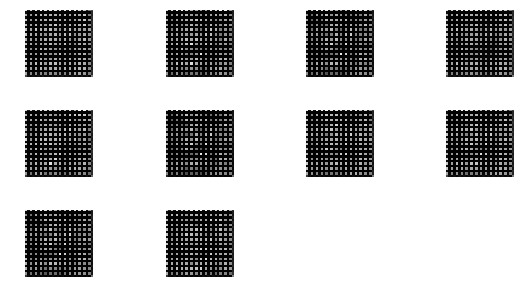

In [26]:
N = 10
noise = np.random.uniform(-1.0, 1.0, size=[N, input_dim]) 
images = G.predict(noise)
import matplotlib.pyplot as plt
for i in range(images.shape[0]):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [img_rows, img_cols])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

Observando la imagen superior, se puede observar que no muy buenos resultados fueron alcanzados. Sin embargo, como equipo decidimos probar dos configuraciones adicionales para mejorar los resultados.

**Nueva Arquitectura - Bath size =128 - Adam con learning rate = 0.001**: A diferencia de la arquitectura superior, el tamaño del batch fue aumentado a 128 y el learning rate de Adam se mantuvo (0.001).  El código y cada uno de los resultados obtenidos se pueden encontrar en el archivo: "Tarea 3 - 1.2 - Batch Size 128 .ipynb", presente en el repositorio de github y disponible también en el siguiente enlace: https://colab.research.google.com/drive/1AYqCP0T29fILUP3COo9_-8rY6Tp6kJC- 




El loss y accuracy obtenido para esta arquitectura fue la siguiente: 

<div align="center"><img src="https://vvcap.com/img/x2PfRiklv.png"></div>

Luego de 5000 epochs, las imágenes generadas fueron las siguientes: 

<div align="center"><img src="https://vvcap.com/img/bFUNjh6En.png"></div>

Acorde a la figura superior, podemos apreciar algunos 5, 9 y posiblemente lo que sea un 8 o un 3. **Esta nueva arquitectura entregó mejores resultados que la anterior.**

**Optimizador Adam con learning rate = 0.0001 - Minibatch = 64**,  En esta arquitectura el tamaño del batch se vuelve al valor original (64), sin embargo el learning rate utilizado en el optimizador se reduce a 0.0001. El código utilizado para esta arquitectura está disponible en el repositorio en github dentro del archivo: "Tarea 3 - 1.2 - Adam con lr = 0.0001.ipynb" y puede ser también visto siguiendo el siguiente enlace: https://colab.research.google.com/drive/11Cl7hq8rcrQohK_4eVStup7aOd-Je_tQ 

El loss y accuracy obtenido para esta arquitectura fue el siguiente: 
<div align="center"><img src="https://vvcap.com/img/C8erCuFnv.png"></div>
Las imagenes generadas luego de 5000 epochs, fueron las siguientes: 

<div align="center"><img src="https://vvcap.com/img/dvPABZMYj.png"></div>

En la imagen superior, podemos ver los siguientes números generados: 5, 2, y 7, entre otros. 

**¿Cuál escoger?** Luego de una evaluación cualitativa, como equipo hemos decidido que la que entrega mejor resultados es la última arquitectura (Optimizador Adam con un learning rate de =0.0001 y minibatch = 64)




### 1.2.f)

> f) ¿Qué le parece que resulta más crucial al momento de entrenar las GAN, saber que se tiene un buen generador e intentar mejorar el discriminador o saber que se tiene un buen discriminador e intentar mejorar el generador? en ambos casos para que el generador mejore. Experimente con una de las ideas, modifique el generador o el discriminador e intente generar mejores imágenes artificiales.

Una de las idea fue entrenar un numero K de veces el discriminador ante una misma interación de entrenamiento del generador, tal como se señala en el siguiente paper: https://arxiv.org/pdf/1406.2661.pdf. Aquí se describe el siguiente algoritmo: 
<div align="center"><img src= "https://vvcap.com/img/EnZCVIc1G.png"></div>

Los resultados considerando un numero  K = 5, son los siguientes:

In [32]:


## Discriminator
D = Sequential()
depth = 64
dropout = 0.4
input_shape = (img_rows, img_cols, channel)
D.add(Conv2D(depth*1, (5,5), strides=2, input_shape=input_shape,padding='same', activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*2, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*4, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Flatten())
D.add(Dense(1024,activation=LeakyReLU(alpha=0.2)))
D.add(Dense(1,activation='sigmoid'))
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_13 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_14 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_15 (Dropout)         (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 4096)              0         
__________

/usr/local/lib/python3.6/dist-packages/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [33]:

## Generator
G = Sequential()
dim = 14
input_dim= 2 #para que sea similar al vAE
G.add(Dense(128, input_dim=input_dim))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Dense(dim*dim*depth))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Reshape((dim, dim, depth)))
G.add(Conv2DTranspose(int(depth/2), (3,3), padding='same',strides=(2,2)))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Conv2DTranspose(int(depth/2), (3,3), padding='same'))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Conv2DTranspose(channel, (3,3), padding='same')) 
G.add(Activation('sigmoid')) 
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 128)               384       
_________________________________________________________________
batch_normalization_13 (Batc (None, 128)               512       
_________________________________________________________________
activation_16 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 12544)             1618176   
_________________________________________________________________
batch_normalization_14 (Batc (None, 12544)             50176     
_________________________________________________________________
activation_17 (Activation)   (None, 12544)             0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 14, 14, 64)        0         
__________

In [0]:


## Discriminator model (police)
#optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
optimizer = Adam(0.0001)
DM = Sequential()
DM.add(D)
DM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
## Adversarial model (Generator->Discriminator)
D.trainable=False #set the discriminator freeze  (fixed params)
#optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
optimizer = Adam(lr = 0.0001)
AM = Sequential()
AM.add(G)
AM.add(D)
AM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])


In [0]:
def train_on_steps(X_train,DM,AM,G,steps,batch_size, k):
    history = {"d":[],"g":[]}
    for e in range(train_steps):
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=batch_size),:,:,:] #sample images from real data
        noise_gen = np.random.uniform(-1,1,size=[batch_size,input_dim]) #sample image from generated data
        generated_images = G.predict(noise_gen) #fake images
        # Train discriminator on generated images
        for i in range(k):
          X = np.concatenate((image_batch, generated_images))
          #create labels
          y = np.ones([2*batch_size,1])
          y[batch_size:,:] = 0
          d_loss  = DM.train_on_batch(X,y)
        history["d"].append(d_loss)
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(-1,1,size=[batch_size,input_dim])
        y = np.ones([batch_size, 1])
        g_loss = AM.train_on_batch(noise_tr, y)
        history["g"].append(g_loss)
        log_mesg = "%d: [D loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [G loss: %f, acc: %f]" % (log_mesg, g_loss[0], g_loss[1])
        print(log_mesg)
    return history

In [36]:
train_steps = 5000 #or few if  you want
hist = train_on_steps(X_train,DM,AM,G,train_steps,64,5)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [D loss: 0.609273, acc: 0.507812]  [G loss: 1.101422, acc: 0.000000]
1: [D loss: 0.465975, acc: 0.609375]  [G loss: 1.955685, acc: 0.000000]
2: [D loss: 0.251418, acc: 1.000000]  [G loss: 2.143448, acc: 0.000000]
3: [D loss: 0.061767, acc: 1.000000]  [G loss: 4.516418, acc: 0.000000]
4: [D loss: 0.010395, acc: 1.000000]  [G loss: 7.165132, acc: 0.000000]
5: [D loss: 0.001690, acc: 1.000000]  [G loss: 7.826030, acc: 0.000000]
6: [D loss: 0.001266, acc: 1.000000]  [G loss: 10.897379, acc: 0.000000]
7: [D loss: 0.000540, acc: 1.000000]  [G loss: 12.950418, acc: 0.000000]
8: [D loss: 0.000353, acc: 1.000000]  [G loss: 13.018766, acc: 0.000000]
9: [D loss: 0.000138, acc: 1.000000]  [G loss: 14.264829, acc: 0.000000]
10: [D loss: 0.000539, acc: 1.000000]  [G loss: 13.338332, acc: 0.000000]
11: [D loss: 0.000263, acc: 1.000000]  [G loss: 14.236749, acc: 0.000000]
12: [D loss: 0.001308, acc: 1.000000]  [G loss: 15.822754, acc: 0.000000]
13: [D loss: 0.000607, acc: 1.000000]  [G loss: 15.074

In [0]:
loss_discriminador = [] 
acc_discriminador = [] 
loss_generador = []
acc_generador = []

for loss, acc in hist['d']:
  loss_discriminador.append(loss)
  acc_discriminador.append(acc)

for loss, acc in hist['g']:
  loss_generador.append(loss)
  acc_generador.append(acc)



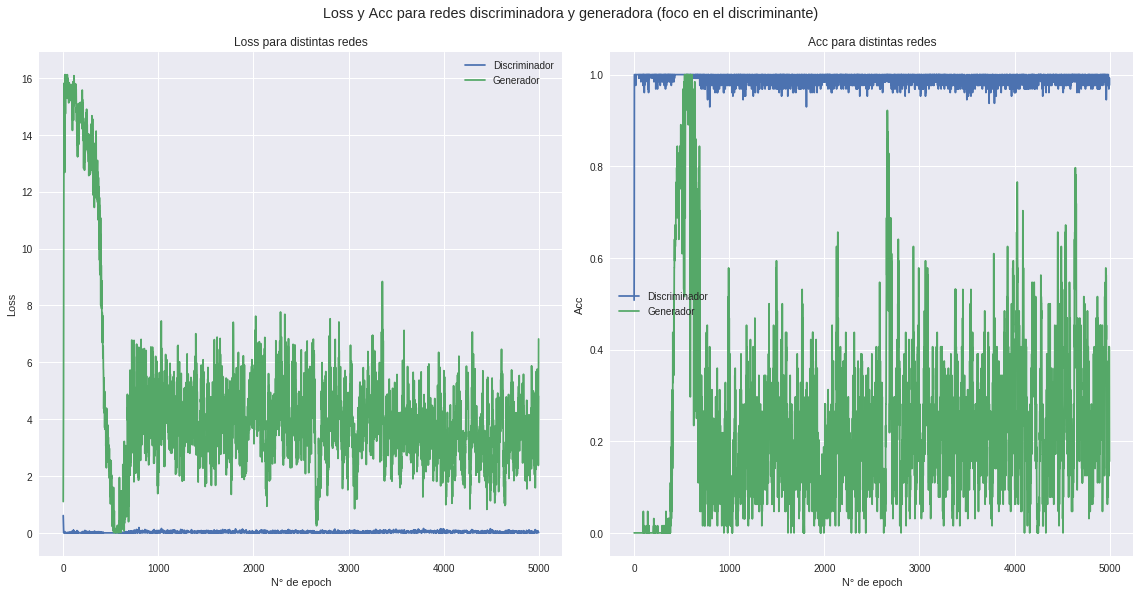

In [39]:
plt.figure(6, figsize=(16,8))
plt.suptitle("Loss y Acc para redes discriminadora y generadora (foco en el discriminante)", y=1.03)
plt.subplot(121)
plt.title("Loss para distintas redes")
plt.plot(loss_discriminador, label = "Discriminador")
plt.plot(loss_generador, label="Generador")
plt.ylabel("Loss")
plt.xlabel("N° de epoch")
plt.legend()
plt.tight_layout()
plt.subplot(122)
plt.title("Acc para distintas redes")
plt.plot(acc_discriminador, label = "Discriminador")
plt.plot(acc_generador, label="Generador")
plt.ylabel("Acc")
plt.xlabel("N° de epoch")
plt.legend()
plt.tight_layout()
plt.show();

En las imagenes superiores podemos ver que se priviligió demasiado el discriminador, la pérdida disminuyó considerablemente y se alcanzó un muy buen accurcy de esta red.  Sin embargo, el accuracy del generador fue muy variable durante las iteraciones, es bastante inestable.

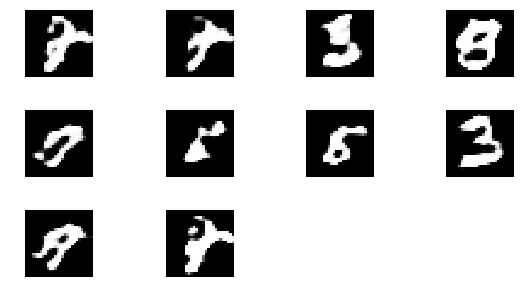

In [40]:
N = 10
noise = np.random.uniform(-1.0, 1.0, size=[N, input_dim]) 
images = G.predict(noise)
import matplotlib.pyplot as plt
for i in range(images.shape[0]):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [img_rows, img_cols])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

De acuerdo a la figura superior, podemos ver que la red pudo generar el número 3y 8 bastante bien. Otros dígito son dificiles de distinguir. 

#### Enfocarse en el Generador

Siguiendo la idea anterior, en este caso se decide enfocarse en el generador aumentando el número de iteraciones en que se entrena en comparación al número de iteraciones que se realiza el entrenamiento del discriminador. El número 'k' será igual a 5.

In [48]:
D = Sequential()
depth = 64
dropout = 0.4
input_shape = (img_rows, img_cols, channel)
D.add(Conv2D(depth*1, (5,5), strides=2, input_shape=input_shape,padding='same', activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*2, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*4, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Flatten())
D.add(Dense(1024,activation=LeakyReLU(alpha=0.2)))
D.add(Dense(1,activation='sigmoid'))
#D.summary()

/usr/local/lib/python3.6/dist-packages/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [0]:
G = Sequential()
dim = 14
input_dim= 2 #para que sea similar al vAE
G.add(Dense(128, input_dim=input_dim))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Dense(dim*dim*depth))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Reshape((dim, dim, depth)))
G.add(Conv2DTranspose(int(depth/2), (3,3), padding='same',strides=(2,2)))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Conv2DTranspose(int(depth/2), (3,3), padding='same'))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Conv2DTranspose(channel, (3,3), padding='same')) 
G.add(Activation('sigmoid')) 
#G.summary()

In [0]:
## Discriminator model (police)
#optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
optimizer = Adam(0.001)
DM = Sequential()
DM.add(D)
DM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
## Adversarial model (Generator->Discriminator)
D.trainable=False #set the discriminator freeze  (fixed params)
#optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
optimizer = Adam(lr = 0.0001)
AM = Sequential()
AM.add(G)
AM.add(D)
AM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

In [51]:

def train_on_steps(X_train,DM,AM,G,steps,batch_size,k):
    history = {"d":[],"g":[]}
    for e in range(train_steps):
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=batch_size),:,:,:] #sample images from real data
        noise_gen = np.random.uniform(-1,1,size=[batch_size,input_dim]) #sample image from generated data
        generated_images = G.predict(noise_gen) #fake images
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        #create labels
        y = np.ones([2*batch_size,1])
        y[batch_size:,:] = 0
        d_loss  = DM.train_on_batch(X,y)
        history["d"].append(d_loss)
        # train Generator-Discriminator stack on input noise to non-generated output class
        for i in range(k):
          noise_tr = np.random.uniform(-1,1,size=[batch_size,input_dim])
          y = np.ones([batch_size, 1])
          g_loss = AM.train_on_batch(noise_tr, y)
        history["g"].append(g_loss)
        log_mesg = "%d: [D loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [G loss: %f, acc: %f]" % (log_mesg, g_loss[0], g_loss[1])
        print(log_mesg)
    return history
train_steps = 5000 #or few if  you want
hist = train_on_steps(X_train,DM,AM,G,train_steps,64,5)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [D loss: 0.689800, acc: 0.531250]  [G loss: 1.026166, acc: 0.000000]
1: [D loss: 0.611257, acc: 0.507812]  [G loss: 1.591894, acc: 0.000000]
2: [D loss: 0.424880, acc: 0.906250]  [G loss: 0.774747, acc: 0.421875]
3: [D loss: 0.435940, acc: 0.710938]  [G loss: 8.105560, acc: 0.000000]
4: [D loss: 0.643752, acc: 0.648438]  [G loss: 6.330370, acc: 0.000000]
5: [D loss: 0.281366, acc: 0.875000]  [G loss: 1.655669, acc: 0.015625]
6: [D loss: 0.143482, acc: 0.968750]  [G loss: 0.282857, acc: 0.968750]
7: [D loss: 0.514057, acc: 0.695312]  [G loss: 1.506463, acc: 0.015625]
8: [D loss: 0.069349, acc: 1.000000]  [G loss: 3.817560, acc: 0.000000]
9: [D loss: 0.069142, acc: 0.984375]  [G loss: 5.528325, acc: 0.000000]
10: [D loss: 0.187472, acc: 0.937500]  [G loss: 5.591054, acc: 0.000000]
11: [D loss: 0.226774, acc: 0.906250]  [G loss: 3.781474, acc: 0.000000]
12: [D loss: 0.076076, acc: 0.968750]  [G loss: 1.284253, acc: 0.125000]
13: [D loss: 0.040932, acc: 1.000000]  [G loss: 0.190552, acc

In [0]:
loss_discriminador = [] 
acc_discriminador = [] 
loss_generador = []
acc_generador = []

for loss, acc in hist['d']:
  loss_discriminador.append(loss)
  acc_discriminador.append(acc)

for loss, acc in hist['g']:
  loss_generador.append(loss)
  acc_generador.append(acc)

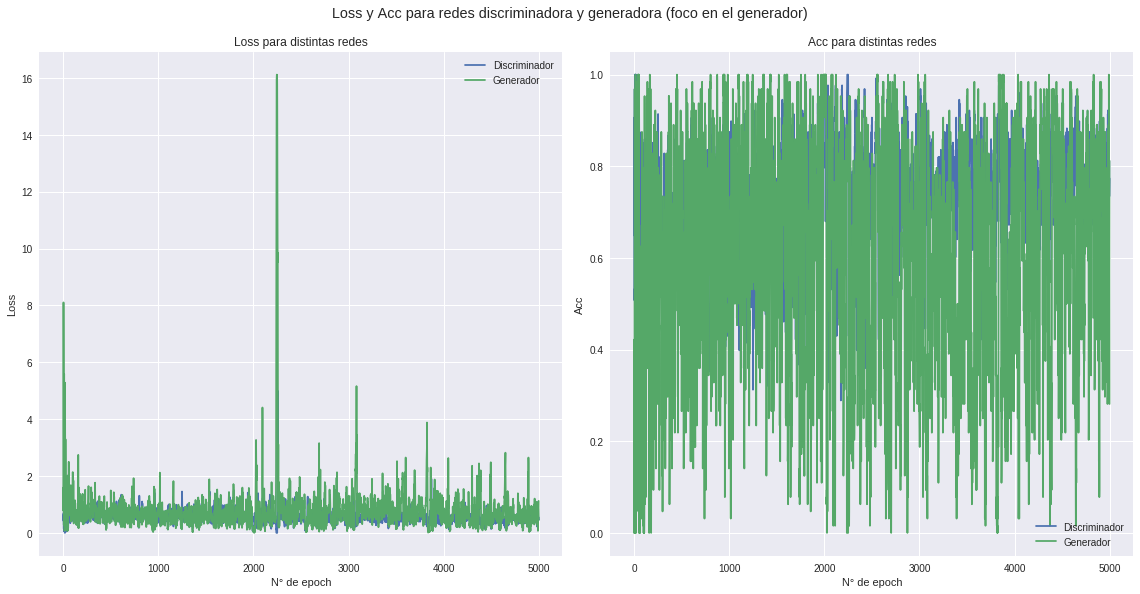

In [53]:
plt.figure(6, figsize=(16,8))
plt.suptitle("Loss y Acc para redes discriminadora y generadora (foco en el generador)", y=1.03)
plt.subplot(121)
plt.title("Loss para distintas redes")
plt.plot(loss_discriminador, label = "Discriminador")
plt.plot(loss_generador, label="Generador")
plt.ylabel("Loss")
plt.xlabel("N° de epoch")
plt.legend()
plt.tight_layout()
plt.subplot(122)
plt.title("Acc para distintas redes")
plt.plot(acc_discriminador, label = "Discriminador")
plt.plot(acc_generador, label="Generador")
plt.ylabel("Acc")
plt.xlabel("N° de epoch")
plt.legend()
plt.tight_layout()
plt.show();

El loss del discriminador y de el generador disminuyen de la misma manera. Sin embargo, el accuracy de la GAN es lo suficientemente inestable a lo largo de los epochs.

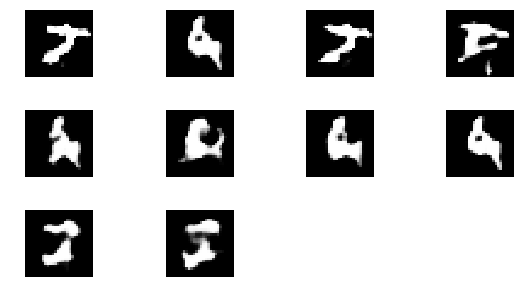

In [54]:
N = 10
noise = np.random.uniform(-1.0, 1.0, size=[N, input_dim]) 
images = G.predict(noise)
import matplotlib.pyplot as plt
for i in range(images.shape[0]):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [img_rows, img_cols])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

Acorde a los resultados anteriores, podemos comprobar que enfocarse en el generador fue una mala idea. La red es lo suficientemente inestable, por lo que no es capaz de generar números correctamente. Dentro de los resultados, la única imagen interpretable es un 5.

### 1.2.g)

> g) ¿Qué pasa al cambiar la distribución latente de los datos $z$? Comente sobre alguna distribución elegida, diferente a la Uniforme, e **implementela** entrenando completamente el modelo.


Se utilizará una distribución  lognormal.

La figura o forma obtenida de una distribución lognormal dependerá de el valor promedio y del valor de la desviación estandar bajo una distribución normal. Este último valor debe ser mayor que cero. En la siguiente forma se ven distintas distribuciones lognormales:

<div align="center"><img src="https://i.investopedia.com/lognormal_distribution.png"></div>

Se aplicará una distribución lognormal con valor promedio = 0 y desviación estandar = 1. (Valores defectos de la función lognormal en numpy. Fuente: https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.lognormal.html#numpy.random.lognormal)

In [67]:
## Discriminator
D = Sequential()
depth = 64
dropout = 0.4
input_shape = (img_rows, img_cols, channel)
D.add(Conv2D(depth*1, (5,5), strides=2, input_shape=input_shape,padding='same', activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*2, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*4, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Flatten())
D.add(Dense(1024,activation=LeakyReLU(alpha=0.2)))
D.add(Dense(1,activation='sigmoid'))
#D.summary()

/usr/local/lib/python3.6/dist-packages/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [0]:
G = Sequential()
dim = 14
input_dim= 2 #para que sea similar al vAE
G.add(Dense(128, input_dim=input_dim))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Dense(dim*dim*depth))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Reshape((dim, dim, depth)))
G.add(Conv2DTranspose(int(depth/2), (3,3), padding='same',strides=(2,2)))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Conv2DTranspose(int(depth/2), (3,3), padding='same'))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Conv2DTranspose(channel, (3,3), padding='same')) 
G.add(Activation('sigmoid')) 
#G.summary()

In [0]:
## Discriminator model (police)
#optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
optimizer = Adam(0.001)
DM = Sequential()
DM.add(D)
DM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
## Adversarial model (Generator->Discriminator)
D.trainable=False #set the discriminator freeze  (fixed params)
#optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
optimizer = Adam(lr = 0.0001)
AM = Sequential()
AM.add(G)
AM.add(D)
AM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])


**Aquí se hace el cambio de distribución**

In [70]:
def train_on_steps(X_train,DM,AM,G,steps,batch_size):
    history = {"d":[],"g":[]}
    for e in range(train_steps):
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=batch_size),:,:,:] #sample images from real data
        #noise_gen = np.random.uniform(-1,1,size=[batch_size,input_dim]) #sample image from generated data
        noise_gen = np.random.lognormal(0,1,size=[batch_size,input_dim]) #AQUI SE CAMBIO LA DISTRIBUCION!
        generated_images = G.predict(noise_gen) #fake images
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        #create labels
        y = np.ones([2*batch_size,1])
        y[batch_size:,:] = 0
        d_loss  = DM.train_on_batch(X,y)
        history["d"].append(d_loss)
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.lognormal(0,1,size=[batch_size,input_dim])
        y = np.ones([batch_size, 1])
        g_loss = AM.train_on_batch(noise_tr, y)
        history["g"].append(g_loss)
        log_mesg = "%d: [D loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [G loss: %f, acc: %f]" % (log_mesg, g_loss[0], g_loss[1])
        print(log_mesg)
    return history
train_steps = 5000 #or few if  you want
hist = train_on_steps(X_train,DM,AM,G,train_steps,64)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [D loss: 0.694824, acc: 0.421875]  [G loss: 1.140566, acc: 0.000000]
1: [D loss: 0.588245, acc: 0.500000]  [G loss: 2.201335, acc: 0.000000]
2: [D loss: 0.341431, acc: 0.960938]  [G loss: 0.564973, acc: 0.781250]
3: [D loss: 0.455707, acc: 0.656250]  [G loss: 8.370114, acc: 0.000000]
4: [D loss: 0.188880, acc: 0.921875]  [G loss: 11.573817, acc: 0.000000]
5: [D loss: 0.383301, acc: 0.828125]  [G loss: 9.135378, acc: 0.000000]
6: [D loss: 0.096266, acc: 0.968750]  [G loss: 5.875665, acc: 0.000000]
7: [D loss: 0.005939, acc: 1.000000]  [G loss: 3.943516, acc: 0.031250]
8: [D loss: 0.048335, acc: 0.992188]  [G loss: 1.865433, acc: 0.265625]
9: [D loss: 0.276669, acc: 0.882812]  [G loss: 3.521797, acc: 0.046875]
10: [D loss: 0.064856, acc: 0.976562]  [G loss: 4.121630, acc: 0.000000]
11: [D loss: 0.042826, acc: 0.984375]  [G loss: 5.774740, acc: 0.015625]
12: [D loss: 0.005254, acc: 1.000000]  [G loss: 6.979190, acc: 0.000000]
13: [D loss: 0.003126, acc: 1.000000]  [G loss: 10.064909, a

In [0]:
loss_discriminador = [] 
acc_discriminador = [] 
loss_generador = []
acc_generador = []

for loss, acc in hist['d']:
  loss_discriminador.append(loss)
  acc_discriminador.append(acc)

for loss, acc in hist['g']:
  loss_generador.append(loss)
  acc_generador.append(acc)

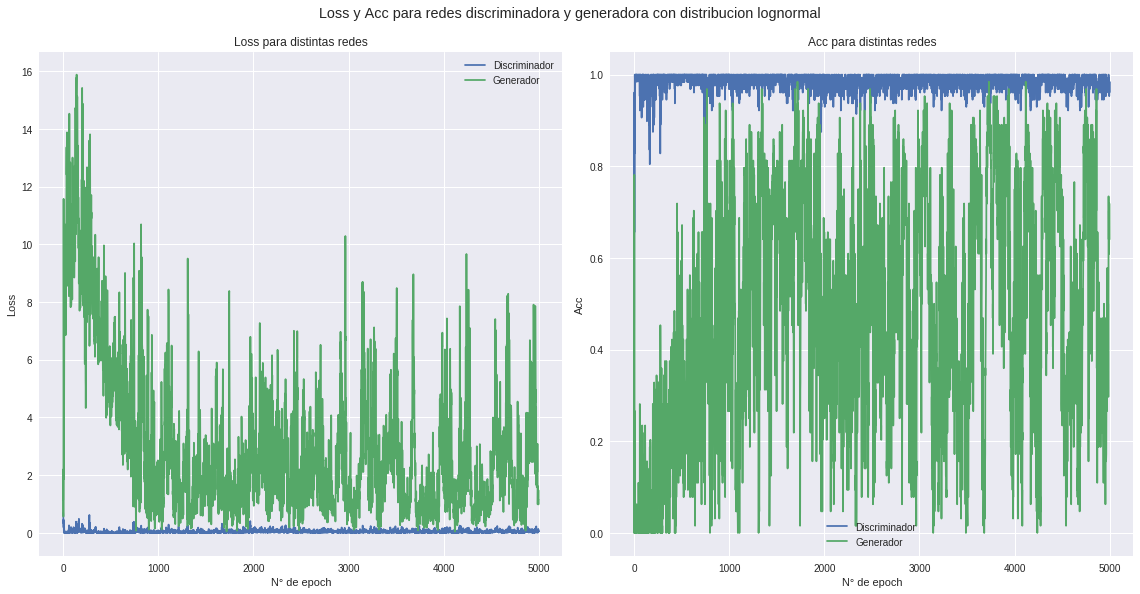

In [72]:
plt.figure(6, figsize=(16,8))
plt.suptitle("Loss y Acc para redes discriminadora y generadora con distribucion lognormal", y=1.03)
plt.subplot(121)
plt.title("Loss para distintas redes")
plt.plot(loss_discriminador, label = "Discriminador")
plt.plot(loss_generador, label="Generador")
plt.ylabel("Loss")
plt.xlabel("N° de epoch")
plt.legend()
plt.tight_layout()
plt.subplot(122)
plt.title("Acc para distintas redes")
plt.plot(acc_discriminador, label = "Discriminador")
plt.plot(acc_generador, label="Generador")
plt.ylabel("Acc")
plt.xlabel("N° de epoch")
plt.legend()
plt.tight_layout()
plt.show();

En la imagen superior se puede ver como el loss del generador tiende a disminuir en el tiempo. El accuracy del generador fluctua en el tiempo.

En la siguiente imagen se pueden ver dígitos generados siguiendo una distribución lognormal:

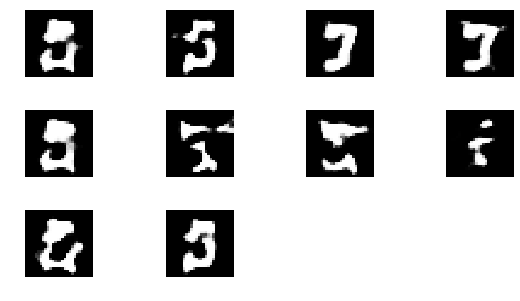

In [73]:
N = 10
noise = np.random.lognormal(0, 1.0, size=[N, input_dim]) 
images = G.predict(noise)
import matplotlib.pyplot as plt
for i in range(images.shape[0]):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [img_rows, img_cols])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

En la imagen superior podemos identificar algunos números: 3 y 5. Si comparamos con resultados anteriores, podemos ver que estas imagenes generadas tienden a ser más anchas o densas 

¿Qué sucede si una vez entrenado este modelo con distribuciones lognormales, se crean imágenes siguiendo una distribución uniformel? Veamos los resultados:

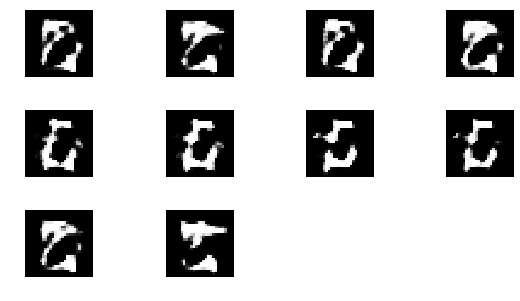

In [74]:
N = 10
noise = np.random.uniform(-1.0, 1.0, size=[N, input_dim]) 
images = G.predict(noise)
import matplotlib.pyplot as plt
for i in range(images.shape[0]):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [img_rows, img_cols])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

Los resultados de este último experimento dejan mucho que desear. Si nos esforzamos podemos ver '2' y '5', pero son muy díficiles de captar. 

### 1.2.h)

> h) Comente sobre el efecto de aumentar la dimensionalidad de las variables a generar datos $z$. Compare con lo acontecido con el método generativo VAE.

** Se probará con dimensionalidad = 5** 

In [0]:
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPool2D
from keras.models import Model
from keras.datasets import mnist
import numpy as np
import keras
from keras.layers import Reshape,Conv2DTranspose,Activation
from keras import backend as K
from keras.layers import Lambda
from keras import utils
import matplotlib.pyplot as plt
from keras.models import load_model
from scipy.stats import norm
from keras.layers import Dropout

In [0]:
from keras.models import Model,Sequential
from keras.layers import LeakyReLU,Conv2D,Dropout,Flatten,Dense
from keras.layers import BatchNormalization,Reshape,UpSampling2D,Conv2DTranspose,Activation
from keras.optimizers import RMSprop
from keras.models import Model,Sequential
from keras.layers import LeakyReLU,Conv2D,Dropout,Flatten,Dense

In [18]:


## Discriminator
D = Sequential()
depth = 64
dropout = 0.4
input_shape = (img_rows, img_cols, channel)
D.add(Conv2D(depth*1, (5,5), strides=2, input_shape=input_shape,padding='same', activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*2, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*4, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Flatten())
D.add(Dense(1024,activation=LeakyReLU(alpha=0.2)))
D.add(Dense(1,activation='sigmoid'))
#D.summary()

/usr/local/lib/python3.6/dist-packages/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


En la siguiente celda se cambia la dimensionalidad de las variables a generar datos

In [0]:
## Generator
G = Sequential()
dim = 14
input_dim= 5 #para que sea similar al vAE
G.add(Dense(128, input_dim=input_dim))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Dense(dim*dim*depth))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Reshape((dim, dim, depth)))
G.add(Conv2DTranspose(int(depth/2), (3,3), padding='same',strides=(2,2)))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Conv2DTranspose(int(depth/2), (3,3), padding='same'))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Conv2DTranspose(channel, (3,3), padding='same')) 
G.add(Activation('sigmoid')) 
#G.summary()

In [0]:
from keras.layers import BatchNormalization,Reshape,UpSampling2D,Conv2DTranspose,Activation

from keras.optimizers import RMSprop
from keras.optimizers import Adam

## Discriminator model (police)
#optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
optimizer = Adam(0.001)
DM = Sequential()
DM.add(D)
DM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
## Adversarial model (Generator->Discriminator)
D.trainable=False #set the discriminator freeze  (fixed params)
#optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
optimizer = Adam(lr = 0.0001)
AM = Sequential()
AM.add(G)
AM.add(D)
AM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

In [23]:

def train_on_steps(X_train,DM,AM,G,steps,batch_size):
    history = {"d":[],"g":[]}
    for e in range(train_steps):
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=batch_size),:,:,:] #sample images from real data
        noise_gen = np.random.uniform(-1,1,size=[batch_size,input_dim]) #sample image from generated data
        generated_images = G.predict(noise_gen) #fake images
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        #create labels
        y = np.ones([2*batch_size,1])
        y[batch_size:,:] = 0
        d_loss  = DM.train_on_batch(X,y)
        history["d"].append(d_loss)
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(-1,1,size=[batch_size,input_dim])
        y = np.ones([batch_size, 1])
        g_loss = AM.train_on_batch(noise_tr, y)
        history["g"].append(g_loss)
        log_mesg = "%d: [D loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [G loss: %f, acc: %f]" % (log_mesg, g_loss[0], g_loss[1])
        print(log_mesg)
    return history
train_steps = 5000 #or few if  you want
hist = train_on_steps(X_train,DM,AM,G,train_steps,64)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [D loss: 0.692641, acc: 0.523438]  [G loss: 1.071439, acc: 0.000000]
1: [D loss: 0.580782, acc: 0.523438]  [G loss: 2.181273, acc: 0.000000]
2: [D loss: 0.348380, acc: 0.937500]  [G loss: 0.977477, acc: 0.109375]
3: [D loss: 0.302334, acc: 0.890625]  [G loss: 8.617358, acc: 0.000000]
4: [D loss: 0.209545, acc: 0.929688]  [G loss: 11.185122, acc: 0.000000]
5: [D loss: 0.139813, acc: 0.937500]  [G loss: 10.765304, acc: 0.000000]
6: [D loss: 0.033377, acc: 0.984375]  [G loss: 8.959898, acc: 0.000000]
7: [D loss: 0.001299, acc: 1.000000]  [G loss: 7.108415, acc: 0.000000]
8: [D loss: 0.001307, acc: 1.000000]  [G loss: 4.567630, acc: 0.000000]
9: [D loss: 0.019097, acc: 1.000000]  [G loss: 4.151275, acc: 0.000000]
10: [D loss: 0.058050, acc: 0.992188]  [G loss: 7.372366, acc: 0.000000]
11: [D loss: 0.005972, acc: 1.000000]  [G loss: 10.768318, acc: 0.000000]
12: [D loss: 0.000732, acc: 1.000000]  [G loss: 13.396000, acc: 0.000000]
13: [D loss: 0.000126, acc: 1.000000]  [G loss: 15.131502

In [0]:
loss_discriminador = [] 
acc_discriminador = [] 
loss_generador = []
acc_generador = []

for loss, acc in hist['d']:
  loss_discriminador.append(loss)
  acc_discriminador.append(acc)

for loss, acc in hist['g']:
  loss_generador.append(loss)
  acc_generador.append(acc)

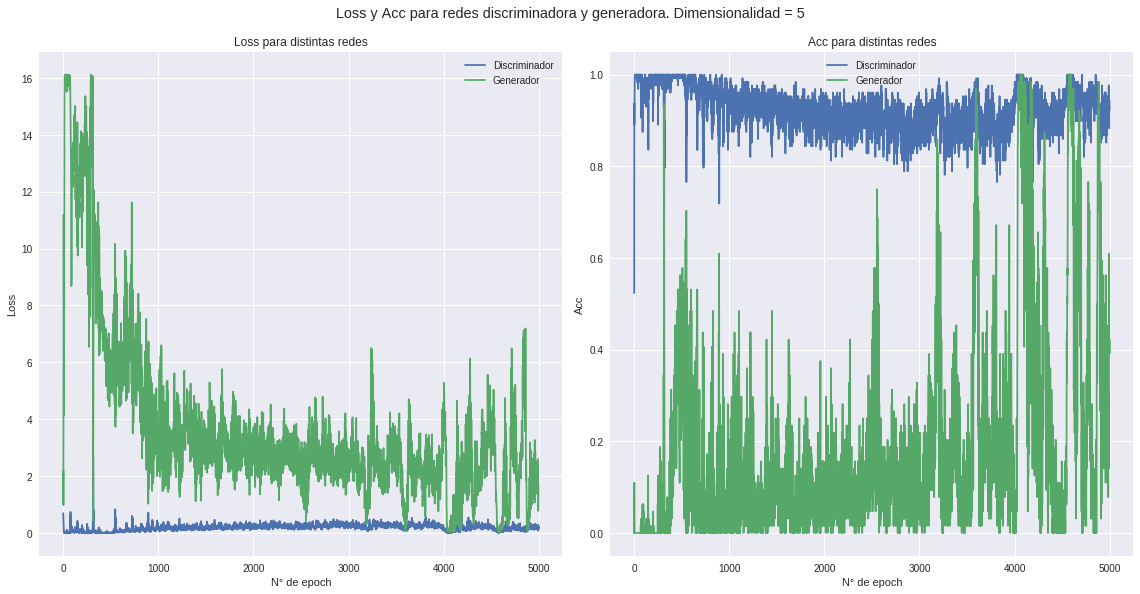

In [25]:
plt.figure(6, figsize=(16,8))
plt.suptitle("Loss y Acc para redes discriminadora y generadora. Dimensionalidad = 5", y=1.03)
plt.subplot(121)
plt.title("Loss para distintas redes")
plt.plot(loss_discriminador, label = "Discriminador")
plt.plot(loss_generador, label="Generador")
plt.ylabel("Loss")
plt.xlabel("N° de epoch")
plt.legend()
plt.tight_layout()
plt.subplot(122)
plt.title("Acc para distintas redes")
plt.plot(acc_discriminador, label = "Discriminador")
plt.plot(acc_generador, label="Generador")
plt.ylabel("Acc")
plt.xlabel("N° de epoch")
plt.legend()
plt.tight_layout()
plt.show();

En la imagen superior podemos ver que el accuracy del generador en los primeros 2000 epochs era bastante bajo. Luego comienza a subir. 

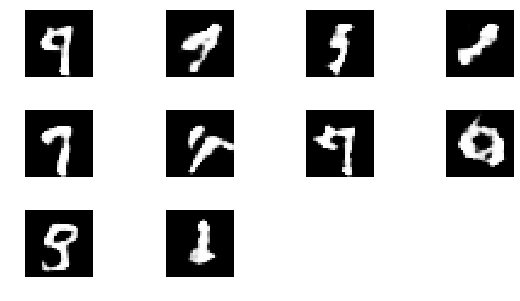

In [26]:
N = 10
noise = np.random.uniform(-1.0, 1.0, size=[N, input_dim]) 
images = G.predict(noise)
import matplotlib.pyplot as plt
for i in range(images.shape[0]):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [img_rows, img_cols])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

La imagen superior muestra imagen generadas considerando una dimensionalidad de los datos = 5. Comparado con los resultados anteriores, podemos ver que en este caso los números tienden a ser al "estilo gotico", presentando peculiares formas. A pesar de lo anterior, es posible distinguir los números. En la imagen podemos ver un 5, 0, 7, 1 y 9. 

Todo hace parecer que aumentar la dimensionalidad permite obtener imagenes un poco más curvas y al estilo gótico. 

Además, las imagenes generadas tienden a parecer más definidas y más faciles de destinguir que las obtenidas con VAE, cuando se realizó el mismo proceso. 

# 2. Question Answering

## a) Carga de datos
*Carge los datos y descríbalos ¿Cuántos ejemplos se tienen para entrenar y para predecir?*

Se tiene un dataset de preguntas y respuestas para entrenar la red. Este dataset tiene preguntas estilo "Trivia", es decir, preguntas sobre hechos con respuestas cortas

a continuación se carga el dataset y se muestra un sample:

In [1]:
import pandas as pd
df_train = pd.read_csv('Tarea3-INF395/train_Q-A.csv')
df_train.dropna(inplace=True)
df_test = pd.read_csv('Tarea3-INF395/test_Q.csv')
df_train.head()

id  \
0  56be85543aeaaa14008c9063   
1  56be85543aeaaa14008c9065   
2  56be85543aeaaa14008c9066   
3  56bf6b0f3aeaaa14008c9601   
4  56bf6b0f3aeaaa14008c9602   

                                            question               answer  
0           When did Beyonce start becoming popular?    in the late 1990s  
1  What areas did Beyonce compete in when she was...  singing and dancing  
2  When did Beyonce leave Destiny's Child and bec...                 2003  
3      In what city and state did Beyonce  grow up?        Houston, Texas  
4         In which decade did Beyonce become famous?           late 1990s

In [2]:
print("Ejemplos de entrenamiento:", df_train.shape[0])
print("Ejemplos de test:", df_test.shape[0])

Ejemplos de entrenamiento: 86821
Ejemplos de test: 11873


## b) Tokenizer

*b) Realice un preprocesamiento simple a los textos de entrada (preguntas) tokenizandolos y pasando a minúsculas para evitar ambiguedad, si desea agregar algun preprocesamiento éxtra ésto se verá reflajado en su nota. A los textos de salida (respuestas) no realice ningún preprocesamiento mas que tokenizar, puesto que para la evaluación se solicita retornar los textos en su forma natural. Comente lo realizado.*

Para facilitar el entrenamiento se tokenizan las oraciones del dataset, quitando las mayúsculas ya que para efectos de una red neuronal, una letra mayúscula y minúscula son completamente distintas, lo cual traería problemas a la hora de realizar el entrenamiento.

Con la tokenización se logra separar todas las palabras que componen las preguntas y respuestas del dataset, un ejemplo se presenta a continuación:

```{python}
from nltk.tokenize import sent_tokenize, word_tokenize
 
data = "All work and no play makes jack a dull boy, all work and no play"
print(word_tokenize(data))

>> ['All', 'work', 'and', 'no', 'play', 'makes', 'jack', 'dull', 'boy', ',', 'all', 'work', 'and', 'no', 'play']
```

In [3]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
train_questions = [word_tokenize(sentence.lower()) for sentence in df_train["question"]] #or processing
test_questions = [word_tokenize(sentence.lower()) for sentence in df_test["question"]]
train_answers = [word_tokenize(sentence) for sentence in df_train["answer"]]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\thena\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## c) Crear vocabularios

*c) Cree un vocabulario para codificar las palabras en las respuestas a generar. Repita el procedimiento para las preguntas. Agrege un símbolo que signifique el fin de la respuesta a generar, así para tener un criterio de cuando una respuesta, valga la redundancia, está efectivamente respondida ¿Cuántas palabras tiene el vocabulario de las respuestas y de las preguntas? ¿Ésto podría ser un problema al momento de entrenar la red para que predizca de entre todas ellas?*

---

Tanto para las preguntas como las respuestas, se crean conjuntos que permiten almacenar todas las palabras únicas de cada set de datos, es decir, sin repeticiones. Además se indexan las palabras creando diccionarios que mapean: índice->palabra y palabra->índice

La creación de estos vocabularios muestra la enorme cantidad de palabras de entrenamiento y testing, se requiere de una red lo suficientemente robusta para poder aprender a manejar un vocabulario tan amplio pero sin caer en overfitting.

Con esto también se puede estudiar cuantas palabras del set de pruebas son exclusivas de éste y por lo tanto, completamente desconocidas para la red, lo que implicaría problemas a la hora de intentar responder las preguntas.


In [4]:
vocab_answer = set()
for sentence in train_answers:
    for word in sentence:
        vocab_answer.add(word)
vocab_answer = ["#end"]+ list(vocab_answer)
print('posibles palabras para respuestas:', len(vocab_answer))
vocabA_indices = {c: i for i, c in enumerate(vocab_answer)}
indices_vocabA = {i: c for i, c in enumerate(vocab_answer)}

# sameforquestions
vocab_question = set()
for sentence in train_questions:
    for word in sentence:
        vocab_question.add(word)
print('posibles palabras para preguntas de entrenamiento:', len(vocab_question))
vocabQ_indices = {c: i for i, c in enumerate(vocab_question)}
indices_vocabQ = {i: c for i, c in enumerate(vocab_question)}

vocab_test_question = set()
for sentence in test_questions:
    for word in sentence:
        vocab_test_question.add(word)
print('posibles palabras para preguntas de test:', len(vocab_test_question))
vocabQT_indices = {c: i for i, c in enumerate(vocab_test_question)}
indices_vocabQT = {i: c for i, c in enumerate(vocab_test_question)}
print("Palabras únicas en test:", len(vocab_test_question - vocab_question))

posibles palabras para respuestas: 47423
posibles palabras para preguntas de entrenamiento: 39476
posibles palabras para preguntas de test: 10321
Palabras únicas en test: 2578


## d) Codificar tokens y padding

*d) Codifique los tokens (palabras) de cada texto que utilizará.*

---

Una vez creados los índices de las palabras para cada vocalubario, se procede a transformar las oraciones para que en vez de palabras directamente, estén compuestas por índices que hacen referencia a estas palabras. Así quedan de la siguiente forma:

```
['All', 'work', 'and', 'no', 'play', 'makes', 'jack', 'dull', 'boy', ',', 'all', 'work', 'and', 'no', 'play']
```
Pasa a ser:

```
[2, 1, 3, 5, 4, 10, 9, 8, 6, 7, 2, 1, 3, 5, 4]

```


In [0]:
X_answers = [[vocabA_indices[palabra] for palabra in sentence] for sentence in train_answers]
Xtrain_question = [[vocabQ_indices[palabra] for palabra in sentence] for sentence in train_questions]
Xtest_question = [[vocabQT_indices[palabra] for palabra in sentence] for sentence in test_questions]

Una vez codificados los tokens,  se procede a agregarle padding a las secuencias de texto, lo que permite que todas queden de la misma extensión, para lograr esto se agrega el caracter de término repetidamente hasta dejar a todas las secuencias del mismo largo.

Se decidió agregarlo al final de cada secuencia para dejar lo "importante" de la secuencia al comienzo y que cuando se llega el caracter de término la string ya no incluye más información significativa.

In [6]:
import numpy as np
max_input_length = np.max(list(map(len,train_questions)))
max_output_length = np.max(list(map(len,train_answers)))+1
from keras.preprocessing import sequence
Xtrain_question = sequence.pad_sequences(Xtrain_question,maxlen=max_input_length,padding='post',value=0)
Xtest_question = sequence.pad_sequences(Xtest_question,maxlen=max_input_length,padding='post',value=0)
X_answers = sequence.pad_sequences(X_answers,maxlen=max_output_length,padding='post',value=vocabA_indices["#end"])

C:\Users\thena\Redes Neuronales\rna\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## e) Definir encoder-decoder

*e) Defina el modelo encoder-decoder con los módulos de atención.
Defina el encoder y las compuertas que utilizará: CuDNNGRU,CuDNNLSTM, RNN u otra. Puede utilizar redes bidireccionales en el encoder ¿Esto mejora el resultado?*

---

Para la implementación de la red, se probaron 3 arquitecturas diferentes las cuales entrenaron por alrededor de 5 horas cada una, éstas son:
* CuDNNLSTM
* CuDNNGRU
* CuDNNLSTM + 1 capa de Dropout
* CuDNNLSTM + 2 capas de Dropout
* CuDNNLSTM + 3 capas de Dropout

La última fue elegida para realizar el resto de la tarea ya que obtuvo los mejores resultados de entrenamiento.

La implementación se presenta a continuación:

In [0]:
from keras.layers import Input,RepeatVector,TimeDistributed,Dense,Embedding,Flatten,Activation,Permute,Lambda, CuDNNLSTM, CuDNNGRU, Dropout
from keras.models import Model
from keras import backend as K
length_output = max_output_length
hidden_dim = 128

Definición de encoder con Embedding y CuDNNLSTM

Se agrega capa de Dropout 0.2 tras el embedding para agregarle robustez al modelo y una vez más después del encoder:

In [0]:
embedding_vector = 64 
encoder_input = Input(shape=(max_input_length,))
embedded = Embedding(input_dim=len(vocabQ_indices),output_dim=embedding_vector,input_length=max_input_length)(encoder_input)
encoder = CuDNNLSTM(hidden_dim, return_sequences=True)(Dropout(0.2)(embedded))
dropped = Dropout(0.2)(encoder)

Se plantea un modelo de atención para el encoder, pero **¿Para qué se usa un modelo de atención?**

El modelo de atención fue propuesto por primera vez por Dzmitry Bahdanau et al. en su paper “Neural Machine Translation by Jointly Learning to Align and Translate” como solución a las limitacion del modelo Encoder-Decoder encodificando una secuencia de entrada a un vector de largo fijo del cual se debe decodificar en cada time step. Esto trae problemas a la hora de lidiar con decodificación de secuencias extensas.

El modelo de atención es propuesto cmo un método de alinamiento y traducción:
* Alineamiento es el problema de traducción de máquina que identifica qué partes del input son relevantes a qué palabras del output.

Así, en vez de decodificar la entrada en un vector de contexto fijo, el modelo de ateción genera un vector de contexto filtrado especificamente para cada time step del output.

![alt text](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/08/Example-of-Attention.png)

Fuente: [How does attention work in encoder-decoder recurrent neural networks](https://machinelearningmastery.com/how-does-attention-work-in-encoder-decoder-recurrent-neural-networks/)

In [0]:
# compute T' importance for each step T
attention = TimeDistributed(Dense(max_output_length, activation='tanh'))(dropped)
# softmax a las antenciones sobre todo T
attention = Permute([2, 1])(attention)
attention = Activation('softmax')(attention) 
attention = Permute([2, 1])(attention)

In [0]:
# apply the attention to encoder
def attention_multiply(vects):
    encoder, attention = vects
    return K.batch_dot(attention,encoder, axes=1)
  
sent_representation = Lambda(attention_multiply)([encoder, attention])
decoder = CuDNNLSTM(hidden_dim, return_sequences=True)(sent_representation)
dropped_decoder = Dropout(0.2)(decoder)
probabilities = TimeDistributed(Dense(len(vocab_answer), activation="softmax"))(dropped_decoder)

In [35]:
model = Model(encoder_input,probabilities)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 60, 64)       2526464     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 60, 64)       0           embedding_3[0][0]                
__________________________________________________________________________________________________
cu_dnnlstm_5 (CuDNNLSTM)        (None, 60, 128)      99328       dropout_4[0][0]                  
__________________________________________________________________________________________________
dropout_5 

## f) Entrenar la red

In [36]:
X_answers = X_answers.reshape(X_answers.shape[0],X_answers.shape[1],1)
model.fit(Xtrain_question,X_answers,epochs=10,batch_size=64,validation_split=0.2, verbose=1)

Train on 69456 samples, validate on 17365 samples
Epoch 1/10
48064/69456 [===================>..........] - ETA: 10:06 - loss: 1.1222

69456/69456 [==============================] - 2242s 32ms/step - loss: 0.9980 - val_loss: 0.8009
Epoch 2/10
27008/69456 [==========>...................] - ETA: 20:02 - loss: 0.6898

69456/69456 [==============================] - 2225s 32ms/step - loss: 0.6935 - val_loss: 0.7957
Epoch 3/10
18560/69456 [=======>......................] - ETA: 23:50 - loss: 0.6686

69456/69456 [==============================] - 2215s 32ms/step - loss: 0.6747 - val_loss: 0.8058
Epoch 4/10
15232/69456 [=====>........................] - ETA: 25:22 - loss: 0.6524

69456/69456 [==============================] - 2214s 32ms/step - loss: 0.6612 - val_loss: 0.8067
Epoch 5/10
13888/69456 [====>.........................] - ETA: 25:59 - loss: 0.6350

69456/69456 [==============================] - 2207s 32ms/step - loss: 0.6483 - val_loss: 0.8178
Epoch 6/10
13312/69456 [====>.........................] - ETA: 26:10 - loss: 0.6342

69456/69456 [==============================] - 2205s 32ms/step - loss: 0.6344 - val_loss: 0.8244
Epoch 7/10
13120/69456 [====>.........................] - ETA: 26:15 - loss: 0.6086

69456/69456 [==============================] - 2206s 32ms/step - loss: 0.6208 - val_loss: 0.8233
Epoch 8/10
13056/69456 [====>.........................] - ETA: 26:16 - loss: 0.5940

69456/69456 [==============================] - 2205s 32ms/step - loss: 0.6076 - val_loss: 0.8270
Epoch 9/10
12992/69456 [====>.........................] - ETA: 26:19 - loss: 0.5911

69456/69456 [==============================] - 2212s 32ms/step - loss: 0.5947 - val_loss: 0.8353
Epoch 10/10
12928/69456 [====>.........................] - ETA: 26:45 - loss: 0.5745

69456/69456 [==============================] - 2232s 32ms/step - loss: 0.5822 - val_loss: 0.8464


El entrenamiento muestra claros síntomas de overfitting ya que la pérdida de validación fue aumentando a medida que pasaban los epochs, esto traerá problemas a la hora de realizar predicciones.

In [0]:
model.save("2f_cudnnlstm_triple_dropout.h5")

La red se guardó para que se pueda volver a cargar y seguir trabajando con sus predicciones en otro momento, por ende se incluye la carga del modelo y su descripción para revisar que todo esté en orden.

In [0]:
from keras.models import load_model
model = load_model("2f_cudnnlstm_triple_dropout.h5")

In [62]:
model.summary();

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 60, 64)       2526464     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 60, 64)       0           embedding_3[0][0]                
__________________________________________________________________________________________________
cu_dnnlstm_5 (CuDNNLSTM)        (None, 60, 128)      99328       dropout_4[0][0]                  
__________________________________________________________________________________________________
dropout_5 

In [0]:
from random import choice

## g) Predicciones de respuestas 
*g) Muestre ejemplos de la predicción del modelo, para ésto genere una función que prediga a través de la distribución de probabilidad de la salida, de la forma que estime conveniente, cada palabra en cada instante de tiempo.*

---


Se procede a probar preguntas del dataset de test y de train para revisar el rendimiento de la red:

In [64]:
# DATASET DE TEST

def predict_words(model,example,diversity):
    #predict example
    sentence = []
    preds = model.predict(np.asarray([example]), verbose = 0)[0]
    for words in preds:
      sentence.append(choice(np.argpartition(words, -diversity)[-diversity:]))
      
    return sentence
n=10
for i in range(n):
    indexs = np.random.randint(0,len(Xtest_question))
    example = Xtest_question[indexs]
    indexes_answer = predict_words(model,example, 3)
    question = df_test["question"][indexs]
    print("Pregunta: ",question)
    answer = ""
    for index in indexes_answer:
        if indices_vocabA[index]=="#end": # el final de la oracion
            break
        else:
            answer+=indices_vocabA[index]+" "
    print("Respuesta: ",answer)
print("Los ha predecido todos!")

Pregunta:  How much is terra preta distributed over the Amazon forest?
Respuesta:  Twickenham 
Pregunta:  Who was the director of the American Geographical Society in 1914?
Respuesta:  Twickenham Parys strata Gestalt Gestalt betrayal daytime 
Pregunta:  How many receptors on a helper T cell must be bound to a MHC:antigen complex in order for the cell to be activated?
Respuesta:  Bóbrka 
Pregunta:  What is the Upati Garden in Polish?
Respuesta:  Bóbrka 
Pregunta:  What mechanism moves coal from a bunker to the firebox?
Respuesta:  mariners betrayal strata 
Pregunta:  When was the Dutch Revolt?
Respuesta:  6,000–8,000 1735 Gestalt strata 
Pregunta:  What does Article 102 of the Treaty of Lisbon prohibit?
Respuesta:  shut Sticky Sticky 
Pregunta:  What antibody is transmitted from the father to the baby?
Respuesta:  Wick betrayal strata betrayal strata 
Pregunta:  How were citizens back in Europe feeling about news from Celeron expedition?
Respuesta:  1735 Gestalt strata strata 
Pregunta:

In [65]:
#DATASET DE TRAIN

n=10
for i in range(n):
    indexs = np.random.randint(0,len(Xtrain_question))
    example = Xtrain_question[indexs]
    indexes_answer = predict_words(model, example, 5)
    question = df_train["question"][indexs]
    print("Pregunta: ",question)
    answer = ""
    for index in indexes_answer:
        if indices_vocabA[index]=="#end": # el final de la oracion
            break
        else:
            answer+=indices_vocabA[index]+" "
    print("Respuesta: ",answer)
print("Los ha predecido todos!")

Pregunta:  Which Bureau prints new dollars?
Respuesta:  Spectre 1735 Gestalt Gestalt 
Pregunta:  Where in Houston is the University of Houston campus located?
Respuesta:  ἀρχι- betrayal daytime Elizabeth strata 
Pregunta:  Which Melbourne based university has campuses in Malaysia?
Respuesta:  155 
Pregunta:  What are the individual images with action called in comics?
Respuesta:  transported weep Gestalt 
Pregunta:  How many days of full sun does Tucson get each year?
Respuesta:  Beatty daytime Dubos strata daytime Gestalt Gestalt 
Pregunta:  When did Spielberg buy Orson Welles' personal script copy from 'The War of the Worlds'?
Respuesta:  155 betrayal Gestalt daytime strata strata Gestalt Gestalt strata Gestalt betrayal betrayal Gestalt betrayal daytime Gestalt betrayal 
Pregunta:  What are otsagorgs?
Respuesta:  Congolais daytime daytime 
Pregunta:  What did Whitehead believe was the fundamental purpose of life?
Respuesta:  Transmission 
Pregunta:  What flourished in Somerset after 

De ambas predicciones se puede ver que la red no es logró entrenarse correctamente para predecir las repsuestes ya que tiende a repetir las mismas expresiones en todas las preguntas.

## h) Evaluación del modelo con el benchmark oficial
*h) Evalúe la calidad de su modelo con la métrica del benchmark, para ésto deberá descargar el archivo evaluation script y el dato dev json de la página oficial del dataset: https://rajpurkar.github.io/SQuAD-explorer/ y ejecutarlo de la siguiente manera dentro del Jupyter Notebook*

---
Se procede a generar las predicciones del modelo y usar el script provisto por Standford para evaluar el rendimiento de la red generada:

In [0]:
import json

In [0]:
dic_predictions = {}
contador = 0
for example,id_e in zip(Xtest_question,df_test["id"]): #todos los ejemplos
    indexes_answer = predict_words(model,example, 3) #predice palabra en cada instante
    answer = ""
    for index in indexes_answer:
        if indices_vocabA[index]=="#end": # el final de la oracion
            continue
        else:
            answer+=indices_vocabA[index]+" "
    dic_predictions[id_e] = answer
    contador+=1
print("Los ha predecido todos!")

In [0]:
json_save = json.dumps(dic_predictions)
archivo = open("predictions","w")
archivo.write(json_save)
archivo.close()

In [55]:
!python evaluate-v2.0.py dev-v2.0.json predictions

{
  "exact": 0.0,
  "f1": 0.00046791506405757224,
  "total": 11873,
  "HasAns_exact": 0.0,
  "HasAns_f1": 0.0009371719898035687,
  "HasAns_total": 5928,
  "NoAns_exact": 0.0,
  "NoAns_f1": 0.0,
  "NoAns_total": 5945
}


El benchmark muestra el mal desempeño que tuvo la red, no se obtuvo ninguna predicción correcta como indica los "exact": 0, por lo que la red, quizás por overfitting, falla rotundamente al recibir palabras fuera del train.

# 3. Object Counting

## Carga y procesamiento del dataset

Primero se realiza la carga de los datos de test y train, como las dimensiones de las imágenes entregadas eran muy grandes se decide aplicar un resize sobre éstas dejándolas en un $1/10$ del tamaño original.

También se experimentó con marcar bordes usando openCV pero fue descartado.

In [1]:
import numpy as np
from skimage.transform import resize
import cv2

data_train = np.load('Tarea3-INF395\\P3\\images_train.npy')
data_test = np.load('Tarea3-INF395\\P3\\images_test.npy')
print(len(data_train))
x_scaled = []
x_scaled_test = []
for img in data_train:
  img = cv2.resize(img, (0,0), fx=0.10, fy=0.10)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  #img = cv2.GaussianBlur(img, (7,7), 3)
  #img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
  #ret, img = cv2.threshold(img, 25, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
  x_scaled.append(img)

  
del data_train
 
for img in data_test:
  img = cv2.resize(img, (0,0), fx=0.10, fy=0.10)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  #img = cv2.GaussianBlur(img, (7,7), 3)
  #img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
  #ret, img = cv2.threshold(img, 25, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
  x_scaled_test.append(img)

print(x_scaled[0].shape)
#data_train = data_train/ 255.0
#data_test = data_test/ 255.0

1600
(48, 64, 3)


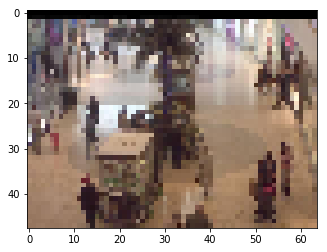

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(x_scaled[0]);

Se normalizan los valores para que las activaciones de la capa de entrada sean entre 0-1.

In [3]:
x_scaled = np.asarray(x_scaled)
x_scaled = x_scaled/255.0

x_scaled_test = np.asarray(x_scaled_test)
x_scaled_test = x_scaled_test/255.0
print(x_scaled.shape)

(1600, 48, 64, 3)


In [4]:
import pandas as pd
import keras
train_Y = pd.read_csv("Tarea3-INF395\\P3\\labels_train.csv")

C:\Users\thena\Redes Neuronales\rna\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
num_classes = train_Y['count'].max() + 1
train_Y = keras.utils.to_categorical(train_Y['count'], num_classes)#/train_Y['count'].max() train_Y['count']
print(train_Y.shape)

(1600, 51)


## Modelo iniciales

Se plantearon 3 approaches iniciales:
* Clasificación categórica de la cantidad de personas.
* Salida lineal.
* Suma de activaciones de capa convolucional

El modelo elegido por su desempeño fue el categórico.

In [63]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,AveragePooling2D,Flatten,Dropout, Activation, Lambda
import keras.backend as K
from keras.optimizers import SGD, Adam
model = Sequential()
model.add(Conv2D(32, (7, 7), padding='same',input_shape=(192, 256, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (7, 7), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (5, 5),padding='same',activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
#model.add(Lambda(lambda x: K.sum(x), output_shape=[1]))
model.add(Dense(100, activation="relu"))
model.add(Dense(num_classes, activation="softmax"))
#model.add(Dense(1, activation="linear"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_82 (Conv2D)           (None, 192, 256, 32)      4736      
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 96, 128, 32)       0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 96, 128, 32)       50208     
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 48, 64, 32)        0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 48, 64, 32)        25632     
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 24, 32, 32)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 24576)             0         
__________

Se entrena el modelo usando SGD y se procede a entrenar por 100 epochs:

In [65]:
optimizer_ = SGD(lr = 0.1, momentum=0.9)
model.compile(loss='mse', optimizer=optimizer_, metrics=['accuracy'])
results = model.fit(x_scaled, train_Y, batch_size=128, epochs=100,verbose=2)

Epoch 1/100
 - 7s - loss: 0.0190 - acc: 0.0606
Epoch 2/100
 - 6s - loss: 0.0189 - acc: 0.0688
Epoch 3/100
 - 6s - loss: 0.0189 - acc: 0.0688
Epoch 4/100
 - 6s - loss: 0.0189 - acc: 0.0650
Epoch 5/100
 - 7s - loss: 0.0189 - acc: 0.0606
Epoch 6/100
 - 6s - loss: 0.0189 - acc: 0.0688
Epoch 7/100
 - 6s - loss: 0.0189 - acc: 0.0619
Epoch 8/100
 - 6s - loss: 0.0189 - acc: 0.0675
Epoch 9/100
 - 6s - loss: 0.0189 - acc: 0.0594
Epoch 10/100
 - 6s - loss: 0.0189 - acc: 0.0675
Epoch 11/100
 - 6s - loss: 0.0189 - acc: 0.0688
Epoch 12/100
 - 7s - loss: 0.0189 - acc: 0.0688
Epoch 13/100
 - 7s - loss: 0.0189 - acc: 0.0537
Epoch 14/100
 - 7s - loss: 0.0189 - acc: 0.0575
Epoch 15/100
 - 6s - loss: 0.0189 - acc: 0.0688
Epoch 16/100
 - 6s - loss: 0.0189 - acc: 0.0681
Epoch 17/100
 - 6s - loss: 0.0189 - acc: 0.0669
Epoch 18/100
 - 7s - loss: 0.0189 - acc: 0.0562
Epoch 19/100
 - 6s - loss: 0.0189 - acc: 0.0688
Epoch 20/100
 - 6s - loss: 0.0189 - acc: 0.0688
Epoch 21/100
 - 6s - loss: 0.0189 - acc: 0.0600
E

In [76]:
predY = model.predict(x_scaled_test)
predY = [np.argmax(x) for x in predY]
print(predY[:20])
import pandas as pd
d = {'id': range(1,len(x_scaled_test)+1), 'count': predY}
entrega = pd.DataFrame(data=d,columns=['id','count'])
entrega.to_csv('mysubmission.csv', index=False)

[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]


Se puede ver que este modelo entrega como resultado 30 independiente del input ya que aprendió a entregar la media de los datos.

## Modelo 2: Data augmentation

Se considera un modelo más robusto y complejo, con más capas de pooling y dropout para evitar problemas de overfitting por la poca cantidad de datos.


In [0]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,AveragePooling2D,Flatten,Dropout, Activation, Lambda
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam
model = Sequential()

model.add(Conv2D(35, (3, 3), padding='same',
                 data_format="channels_last",
                 input_shape=x_scaled[0].shape))
model.add(Activation('relu'))
model.add(Conv2D(35, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(70, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(70, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(560))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

Se agrega data augmentation ya que se planteó que podría tener una red más robusta pero con más lento entrenamiento.


In [0]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(x_scaled)

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 64, 35)        980       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 64, 35)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 62, 35)        11060     
_________________________________________________________________
activation_2 (Activation)    (None, 46, 62, 35)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 31, 35)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 31, 35)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 31, 70)        22120     
__________

In [9]:
model.fit_generator(datagen.flow(x_scaled, train_Y, batch_size=128), workers=12, verbose=2,
                    steps_per_epoch=len(x_scaled) / 32, epochs=1000)

Epoch 1/1000
 - 12s - loss: 3.6753 - acc: 0.0553
Epoch 2/1000
 - 7s - loss: 3.5189 - acc: 0.0563
Epoch 3/1000
 - 7s - loss: 3.4877 - acc: 0.0573
Epoch 4/1000
 - 7s - loss: 3.4646 - acc: 0.0617
Epoch 5/1000
 - 7s - loss: 3.4645 - acc: 0.0580
Epoch 6/1000
 - 7s - loss: 3.4468 - acc: 0.0567
Epoch 7/1000
 - 6s - loss: 3.4384 - acc: 0.0595
Epoch 8/1000
 - 7s - loss: 3.4323 - acc: 0.0626
Epoch 9/1000
 - 7s - loss: 3.4190 - acc: 0.0580
Epoch 10/1000
 - 7s - loss: 3.4229 - acc: 0.0586
Epoch 11/1000
 - 7s - loss: 3.4111 - acc: 0.0574
Epoch 12/1000
 - 7s - loss: 3.4110 - acc: 0.0578
Epoch 13/1000
 - 6s - loss: 3.4090 - acc: 0.0580
Epoch 14/1000
 - 7s - loss: 3.4011 - acc: 0.0597
Epoch 15/1000
 - 7s - loss: 3.3934 - acc: 0.0566
Epoch 16/1000
 - 7s - loss: 3.3878 - acc: 0.0611
Epoch 17/1000
 - 7s - loss: 3.3769 - acc: 0.0601
Epoch 18/1000
 - 7s - loss: 3.3713 - acc: 0.0644
Epoch 19/1000
 - 7s - loss: 3.3585 - acc: 0.0645
Epoch 20/1000
 - 6s - loss: 3.3536 - acc: 0.0653
Epoch 21/1000
 - 7s - loss: 

In [10]:
model.fit_generator(datagen.flow(x_scaled, train_Y, batch_size=128), workers=12, verbose=2,
                    steps_per_epoch=len(x_scaled) / 32, epochs=1000)

Epoch 1/1000
 - 7s - loss: 1.9441 - acc: 0.3234
Epoch 2/1000
 - 7s - loss: 1.9461 - acc: 0.3283
Epoch 3/1000
 - 7s - loss: 1.9612 - acc: 0.3353
Epoch 4/1000
 - 7s - loss: 1.9574 - acc: 0.3321
Epoch 5/1000
 - 7s - loss: 1.9578 - acc: 0.3229
Epoch 6/1000
 - 7s - loss: 1.9776 - acc: 0.3141
Epoch 7/1000
 - 7s - loss: 1.9463 - acc: 0.3277
Epoch 8/1000
 - 7s - loss: 1.9564 - acc: 0.3273
Epoch 9/1000
 - 7s - loss: 1.9315 - acc: 0.3403
Epoch 10/1000
 - 7s - loss: 1.9474 - acc: 0.3272
Epoch 11/1000
 - 7s - loss: 1.9421 - acc: 0.3392
Epoch 12/1000
 - 7s - loss: 1.9664 - acc: 0.3195
Epoch 13/1000
 - 7s - loss: 1.9155 - acc: 0.3272
Epoch 14/1000
 - 7s - loss: 1.9411 - acc: 0.3280
Epoch 15/1000
 - 7s - loss: 1.9722 - acc: 0.3217
Epoch 16/1000
 - 7s - loss: 1.9426 - acc: 0.3331
Epoch 17/1000
 - 7s - loss: 1.9713 - acc: 0.3283
Epoch 18/1000
 - 7s - loss: 1.9130 - acc: 0.3389
Epoch 19/1000
 - 7s - loss: 1.9558 - acc: 0.3194
Epoch 20/1000
 - 6s - loss: 1.9416 - acc: 0.3356
Epoch 21/1000
 - 7s - loss: 1

In [11]:
model.fit_generator(datagen.flow(x_scaled, train_Y, batch_size=128), workers=12, verbose=2,
                    steps_per_epoch=len(x_scaled) / 32, epochs=1000)

Epoch 1/1000
 - 7s - loss: 1.0761 - acc: 0.6234
Epoch 2/1000
 - 7s - loss: 1.0384 - acc: 0.6234
Epoch 3/1000
 - 7s - loss: 1.0582 - acc: 0.6278
Epoch 4/1000
 - 7s - loss: 1.0631 - acc: 0.6274
Epoch 5/1000
 - 7s - loss: 1.0713 - acc: 0.6194
Epoch 6/1000
 - 7s - loss: 1.0553 - acc: 0.6353
Epoch 7/1000
 - 6s - loss: 1.0666 - acc: 0.6207
Epoch 8/1000
 - 7s - loss: 1.0883 - acc: 0.6228
Epoch 9/1000
 - 7s - loss: 1.0443 - acc: 0.6256
Epoch 10/1000
 - 7s - loss: 1.0578 - acc: 0.6213
Epoch 11/1000
 - 7s - loss: 1.0912 - acc: 0.6139
Epoch 12/1000
 - 7s - loss: 1.0510 - acc: 0.6260
Epoch 13/1000
 - 6s - loss: 1.0650 - acc: 0.6209
Epoch 14/1000
 - 7s - loss: 1.0824 - acc: 0.6133
Epoch 15/1000
 - 7s - loss: 1.0594 - acc: 0.6184
Epoch 16/1000
 - 7s - loss: 1.0476 - acc: 0.6273
Epoch 17/1000
 - 7s - loss: 1.0292 - acc: 0.6412
Epoch 18/1000
 - 7s - loss: 1.0209 - acc: 0.6377
Epoch 19/1000
 - 7s - loss: 1.0544 - acc: 0.6219
Epoch 20/1000
 - 6s - loss: 1.0414 - acc: 0.6303
Epoch 21/1000
 - 7s - loss: 1

In [12]:
predY = model.predict(x_scaled_test)
predY = [np.argmax(x) for x in predY]
print(predY[:20])
import pandas as pd
d = {'id': range(1,len(x_scaled_test)+1), 'count': predY}
entrega = pd.DataFrame(data=d,columns=['id','count'])
entrega.to_csv('mysubmissionV2datagen78.csv', index=False)

[19, 23, 18, 18, 18, 18, 18, 18, 18, 19, 18, 19, 18, 18, 19, 19, 23, 19, 18, 18]


In [0]:
model.save("3_datagen_3000_78.h5")

In [14]:
model.fit_generator(datagen.flow(x_scaled, train_Y, batch_size=128), workers=12, verbose=2,
                    steps_per_epoch=len(x_scaled) / 32, epochs=1000)

Epoch 1/1000
 - 9s - loss: 0.6371 - acc: 0.7785
Epoch 2/1000
 - 9s - loss: 0.6494 - acc: 0.7670
Epoch 3/1000
 - 9s - loss: 0.6352 - acc: 0.7800
Epoch 4/1000
 - 9s - loss: 0.6421 - acc: 0.7747
Epoch 5/1000
 - 9s - loss: 0.6174 - acc: 0.7881
Epoch 6/1000
 - 9s - loss: 0.6364 - acc: 0.7777
Epoch 7/1000
 - 8s - loss: 0.6217 - acc: 0.7797
Epoch 8/1000
 - 9s - loss: 0.6107 - acc: 0.7883
Epoch 9/1000
 - 9s - loss: 0.6302 - acc: 0.7772
Epoch 10/1000
 - 9s - loss: 0.6241 - acc: 0.7795
Epoch 11/1000
 - 9s - loss: 0.6258 - acc: 0.7789
Epoch 12/1000
 - 9s - loss: 0.6136 - acc: 0.7812
Epoch 13/1000
 - 8s - loss: 0.6164 - acc: 0.7781
Epoch 14/1000
 - 9s - loss: 0.6276 - acc: 0.7783
Epoch 15/1000
 - 9s - loss: 0.6030 - acc: 0.7889
Epoch 16/1000
 - 9s - loss: 0.6143 - acc: 0.7872
Epoch 17/1000
 - 8s - loss: 0.6372 - acc: 0.7747
Epoch 18/1000
 - 9s - loss: 0.6372 - acc: 0.7822
Epoch 19/1000
 - 9s - loss: 0.5932 - acc: 0.7895
Epoch 20/1000
 - 8s - loss: 0.6040 - acc: 0.7856
Epoch 21/1000
 - 9s - loss: 0

In [0]:
model.save("3_datagen_4000_85.h5")

In [0]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=0,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(x_scaled)

In [17]:
model.fit_generator(datagen.flow(x_scaled, train_Y, batch_size=128), workers=12, verbose=2,
                    steps_per_epoch=len(x_scaled) / 32, epochs=1000)

Epoch 1/1000
 - 9s - loss: 0.3900 - acc: 0.8681
Epoch 2/1000
 - 8s - loss: 0.3863 - acc: 0.8648
Epoch 3/1000
 - 8s - loss: 0.3763 - acc: 0.8683
Epoch 4/1000
 - 8s - loss: 0.3508 - acc: 0.8722
Epoch 5/1000
 - 8s - loss: 0.3549 - acc: 0.8777
Epoch 6/1000
 - 8s - loss: 0.3661 - acc: 0.8717
Epoch 7/1000
 - 8s - loss: 0.3617 - acc: 0.8752
Epoch 8/1000
 - 8s - loss: 0.3508 - acc: 0.8738
Epoch 9/1000
 - 8s - loss: 0.3659 - acc: 0.8713
Epoch 10/1000
 - 9s - loss: 0.3509 - acc: 0.8734
Epoch 11/1000
 - 9s - loss: 0.3528 - acc: 0.8775
Epoch 12/1000
 - 8s - loss: 0.3464 - acc: 0.8773
Epoch 13/1000
 - 8s - loss: 0.3768 - acc: 0.8717
Epoch 14/1000
 - 8s - loss: 0.3775 - acc: 0.8700
Epoch 15/1000
 - 8s - loss: 0.3532 - acc: 0.8755
Epoch 16/1000
 - 8s - loss: 0.3544 - acc: 0.8773
Epoch 17/1000
 - 8s - loss: 0.3626 - acc: 0.8736
Epoch 18/1000
 - 9s - loss: 0.3474 - acc: 0.8755
Epoch 19/1000
 - 8s - loss: 0.3397 - acc: 0.8800
Epoch 20/1000
 - 8s - loss: 0.3540 - acc: 0.8827
Epoch 21/1000
 - 8s - loss: 0

In [0]:
model.save("3_datagen_5000_92.h5")

In [19]:
predY = model.predict(x_scaled_test)
predY = [np.argmax(x) for x in predY]
print(predY[:20])
import pandas as pd
d = {'id': range(1,len(x_scaled_test)+1), 'count': predY}
entrega = pd.DataFrame(data=d,columns=['id','count'])
entrega.to_csv('mysubmissionV2datagen92.csv', index=False)

[26, 26, 26, 26, 26, 26, 23, 23, 23, 23, 23, 23, 23, 23, 23, 26, 26, 26, 23, 26]


Hasta este entonces se entrenó con data aumentada pero se tuvo mal rendimiento en la competencia por lo que se planteó un entrenamiento con los datos originales, esto mostró un claro mal desempeño ya que la accuracy comenzó de muy abajo.

In [20]:
model.fit(x_scaled, train_Y, batch_size=128, epochs=500,verbose=2)

Epoch 1/500
 - 2s - loss: 10.3082 - acc: 0.0500
Epoch 2/500
 - 2s - loss: 3.7389 - acc: 0.0581
Epoch 3/500
 - 2s - loss: 3.6624 - acc: 0.0594
Epoch 4/500
 - 2s - loss: 3.6445 - acc: 0.0594
Epoch 5/500
 - 2s - loss: 3.6283 - acc: 0.0594
Epoch 6/500
 - 2s - loss: 3.6136 - acc: 0.0594
Epoch 7/500
 - 2s - loss: 3.5998 - acc: 0.0594
Epoch 8/500
 - 2s - loss: 3.5919 - acc: 0.0600
Epoch 9/500
 - 2s - loss: 3.5790 - acc: 0.0606
Epoch 10/500
 - 2s - loss: 3.5709 - acc: 0.0625
Epoch 11/500
 - 2s - loss: 3.5627 - acc: 0.0600
Epoch 12/500
 - 2s - loss: 3.5562 - acc: 0.0644
Epoch 13/500
 - 2s - loss: 3.5478 - acc: 0.0581
Epoch 14/500
 - 2s - loss: 3.5437 - acc: 0.0663
Epoch 15/500
 - 2s - loss: 3.5382 - acc: 0.0638
Epoch 16/500
 - 2s - loss: 3.5310 - acc: 0.0606
Epoch 17/500
 - 2s - loss: 3.5278 - acc: 0.0688
Epoch 18/500
 - 2s - loss: 3.5238 - acc: 0.0656
Epoch 19/500
 - 2s - loss: 3.5205 - acc: 0.0700
Epoch 20/500
 - 2s - loss: 3.5146 - acc: 0.0694
Epoch 21/500
 - 2s - loss: 3.5152 - acc: 0.0644


KeyboardInterrupt: ignored

Dado esto se desecha la opción de data augmentation y se plantea un arquitectura similar pero esta vez con los datos originales exclusivamente.

## Modelo Final

In [22]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,AveragePooling2D,Flatten,Dropout, Activation, Lambda
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam
model = Sequential()

model.add(Conv2D(35, (3, 3), padding='same',
                 data_format="channels_last",
                 input_shape=x_scaled[0].shape))
model.add(Activation('relu'))
model.add(Conv2D(35, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(70, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(70, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(560))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Let's train the model using adam
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 48, 64, 35)        980       
_________________________________________________________________
activation_12 (Activation)   (None, 48, 64, 35)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 46, 62, 35)        11060     
_________________________________________________________________
activation_13 (Activation)   (None, 46, 62, 35)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 31, 35)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 23, 31, 35)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 23, 31, 70)        22120     
__________

In [26]:
model.fit(x_scaled, train_Y, batch_size=128, epochs=1500,verbose=2)

Epoch 1/1500
 - 2s - loss: 0.0367 - acc: 0.9881
Epoch 2/1500
 - 2s - loss: 0.0487 - acc: 0.9838
Epoch 3/1500
 - 2s - loss: 0.0606 - acc: 0.9788
Epoch 4/1500
 - 2s - loss: 0.0379 - acc: 0.9894
Epoch 5/1500
 - 2s - loss: 0.0307 - acc: 0.9888
Epoch 6/1500
 - 2s - loss: 0.0372 - acc: 0.9856
Epoch 7/1500
 - 2s - loss: 0.0490 - acc: 0.9869
Epoch 8/1500
 - 2s - loss: 0.0447 - acc: 0.9888
Epoch 9/1500
 - 2s - loss: 0.0509 - acc: 0.9819
Epoch 10/1500
 - 2s - loss: 0.0222 - acc: 0.9931
Epoch 11/1500
 - 2s - loss: 0.0410 - acc: 0.9862
Epoch 12/1500
 - 2s - loss: 0.0426 - acc: 0.9875
Epoch 13/1500
 - 2s - loss: 0.0347 - acc: 0.9888
Epoch 14/1500
 - 2s - loss: 0.0393 - acc: 0.9844
Epoch 15/1500
 - 2s - loss: 0.0450 - acc: 0.9831
Epoch 16/1500
 - 2s - loss: 0.0435 - acc: 0.9888
Epoch 17/1500
 - 2s - loss: 0.0347 - acc: 0.9900
Epoch 18/1500
 - 2s - loss: 0.0377 - acc: 0.9838
Epoch 19/1500
 - 2s - loss: 0.0288 - acc: 0.9919
Epoch 20/1500
 - 2s - loss: 0.0489 - acc: 0.9862
Epoch 21/1500
 - 2s - loss: 0

In [27]:
predY = model.predict(x_scaled_test)
predY = [np.argmax(x) for x in predY]
print(predY[:20])
import pandas as pd
d = {'id': range(1,len(x_scaled_test)+1), 'count': predY}
entrega = pd.DataFrame(data=d,columns=['id','count'])
entrega.to_csv('mysubmissionV3_99.csv', index=False)

[30, 36, 40, 42, 42, 42, 33, 30, 21, 22, 16, 17, 22, 31, 18, 17, 13, 24, 24, 24]
